**Este es un segundo notebook en el que estoy empezando desde 0 para poder probar distintas maneras de modelado.**

**Por lo tanto, hay cosas que ya he visto anteriormente en los primeros intentos de modelado que ya tengo en cuenta (por ejemplo en el anterior notebook ya he hecho feature engineering, por lo que aquí utilizo cosas que se que han funcionado bien en el anterior como la tramificación de algunas variables), sin hacer todo el proceso aquí.**

**El máximo score que conseguí en las versiones anteriores fue un 0.7704.**

Este notebook lo empecé el día 23/04/25

# 1. IMPORTAR LAS LIBRERIAS 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
from datetime import datetime 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import stats
import plotly.express as px
import plotly.graph_objects as go
import mlflow

sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')

import warnings
warnings.filterwarnings('ignore')

# 2. CARGAR LOS DATASETS 

In [2]:
train = pd.read_csv("train.csv")
labels = pd.read_csv("labels.csv")
test = pd.read_csv("test.csv")

In [3]:
#Unir train con labels por 'id'
train_unido= pd.merge(train, labels, on='id')

In [4]:
#Añadir columna 'dataset' para diferenciar 

#mi idea es concatenar los dataset de train y test para poder hacer el preprocesado conjunto, 
#Para ello necesito crear este columna para poder diferenciarlos 

train_unido['dataset'] = 'train'
test['dataset'] = 'test'

In [5]:
#Concatenar ambos datasets
df_concat= pd.concat([train_unido, test], axis=0, ignore_index=True)

In [6]:
#Mostrar primeras filas y shape 
print(df_concat.shape)
df_concat.head()

(74250, 42)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,dataset
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,train
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,train
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,train
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,train
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,train


In [7]:
#Ver información de las variables 
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     74250 non-null  int64  
 1   amount_tsh             74250 non-null  float64
 2   date_recorded          74250 non-null  object 
 3   funder                 69743 non-null  object 
 4   gps_height             74250 non-null  int64  
 5   installer              69718 non-null  object 
 6   longitude              74250 non-null  float64
 7   latitude               74250 non-null  float64
 8   wpt_name               74248 non-null  object 
 9   num_private            74250 non-null  int64  
 10  basin                  74250 non-null  object 
 11  subvillage             73780 non-null  object 
 12  region                 74250 non-null  object 
 13  region_code            74250 non-null  int64  
 14  district_code          74250 non-null  int64  
 15  lg

Veo que hay varias variables que aportan información muy parecida. Creo que lo mejor sería eliminar algunas. 

La idea es hacer un dataframe con menos variables para **reducir la dimensionalidad.**

In [8]:
#Lista de columnas candidatas a ser redundantes 
redundant_columns= [
    'scheme_management', 'scheme_name',
    'management', 'management_group', 
    'extraction_type', 'extraction_type_group', 'extraction_type_class', 
    'water_quality', 'quality_group', 
    'quantity', 'quantity_group', 
    'source', 'source_type', 'source_class', 
    'payment', 'payment_type',
    'waterpoint_type', 'waterpoint_type_group'
]

#Contar cuantos valores únicos hay en cada una da las variables redundantes
unique_values= {
    col: df_concat[df_concat['dataset'] == 'train'][col].nunique()
    for col in redundant_columns
}

#Mostrar los valores únicos 
unique_values

{'scheme_management': 11,
 'scheme_name': 2695,
 'management': 12,
 'management_group': 5,
 'extraction_type': 18,
 'extraction_type_group': 13,
 'extraction_type_class': 7,
 'water_quality': 8,
 'quality_group': 6,
 'quantity': 5,
 'quantity_group': 5,
 'source': 10,
 'source_type': 7,
 'source_class': 3,
 'payment': 7,
 'payment_type': 7,
 'waterpoint_type': 7,
 'waterpoint_type_group': 6}

In [9]:
#Ver las distintas categorías de cada variable para ir decidiendo cual eliminar 
for var in redundant_columns: 
    print(f"Variable: {var}")
    print(df_concat[df_concat['dataset'] == 'train'][var].value_counts(dropna=False))
    print("\n" + "-"*50 + "\n")

Variable: scheme_management
scheme_management
VWC                 36793
WUG                  5206
NaN                  3878
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
Name: count, dtype: int64

--------------------------------------------------

Variable: scheme_name
scheme_name
NaN                     28810
K                         682
Borehole                  546
Chalinze wate             405
M                         400
                        ...  
Mradi wa maji Vijini        1
Villagers                   1
Magundi water supply        1
Saadani Chumv               1
Mtawanya                    1
Name: count, Length: 2696, dtype: int64

--------------------------------------------------

Variable: management
management
vwc                 40507
wug                  6515
water board          2

He decidido quedarme con las siguientes variables: 

- scheme_management
- management_group
- extraction_type_class
- quality_group
- quantity
- source_type
- payment_type
- waterpoint_type_group

In [10]:
#Lista de columnas a eliminar
columns_drop= [
    'scheme_name','management', 'extraction_type', 'extraction_type_group','water_quality',
    'quantity_group', 'source', 'source_class', 'payment', 'waterpoint_type'
]

#Eliminar las columnas que he descartado 
df_concat.drop(columns=columns_drop, inplace=True, errors='ignore')

#Mostrar las dimensiones finales y las primeras columnas para confirmar
print(df_concat.shape)
df_concat.columns.tolist()

(74250, 32)


['id',
 'amount_tsh',
 'date_recorded',
 'funder',
 'gps_height',
 'installer',
 'longitude',
 'latitude',
 'wpt_name',
 'num_private',
 'basin',
 'subvillage',
 'region',
 'region_code',
 'district_code',
 'lga',
 'ward',
 'population',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'permit',
 'construction_year',
 'extraction_type_class',
 'management_group',
 'payment_type',
 'quality_group',
 'quantity',
 'source_type',
 'waterpoint_type_group',
 'status_group',
 'dataset']

In [11]:
df_concat.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,construction_year,extraction_type_class,management_group,payment_type,quality_group,quantity,source_type,waterpoint_type_group,status_group,dataset
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,1999,gravity,user-group,annually,good,enough,spring,communal standpipe,functional,train
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,2010,gravity,user-group,never pay,good,insufficient,rainwater harvesting,communal standpipe,functional,train
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,2009,gravity,user-group,per bucket,good,enough,dam,communal standpipe,functional,train
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,1986,submersible,user-group,never pay,good,dry,borehole,communal standpipe,non functional,train
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,0,gravity,other,never pay,good,seasonal,rainwater harvesting,communal standpipe,functional,train


# 3. PRE-PROCESADO Y LIMPIEZA DE LOS DATOS

In [12]:
#Ver las distintas categorías y valores de las variables del dataframe concatenado 
for i in df_concat.columns:
    print(f"Variable: {i}")
    print(df_concat[i].value_counts())
    print("\n" + "-"*50 + "\n") 

Variable: id
id
69572    1
51488    1
40697    1
40221    1
68749    1
        ..
66431    1
70261    1
26783    1
46768    1
68707    1
Name: count, Length: 74250, dtype: int64

--------------------------------------------------

Variable: amount_tsh
amount_tsh
0.0         52049
500.0        3874
50.0         3103
1000.0       1858
20.0         1812
            ...  
250000.0        1
350000.0        1
5400.0          1
53.0            1
0.5             1
Name: count, Length: 102, dtype: int64

--------------------------------------------------

Variable: date_recorded
date_recorded
2011-03-17    695
2011-03-15    694
2013-02-03    684
2011-03-16    650
2011-03-14    649
             ... 
2011-09-01      1
2011-09-28      1
2011-09-16      1
2011-09-13      1
2004-01-09      1
Name: count, Length: 369, dtype: int64

--------------------------------------------------

Variable: funder
funder
Government Of Tanzania    11299
Danida                     3907
Hesawa                     2782

## 3.1. Tratamiento de Nulos

In [13]:
#Ver cuantos nulos tiene cada variable
df_concat.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    4507
gps_height                   0
installer                 4532
longitude                    0
latitude                     0
wpt_name                     2
num_private                  0
basin                        0
subvillage                 470
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            4155
recorded_by                  0
scheme_management         4847
permit                    3793
construction_year            0
extraction_type_class        0
management_group             0
payment_type                 0
quality_group                0
quantity                     0
source_type                  0
waterpoint_type_group        0
status_group             14850
dataset                      0
dtype: i

Al ser una unión de train y test, vemos que hay más nulos que si solo lo hicieramos de train. 

Por ejemplo, la variable status_group (target) solo tiene nulos en el test, lo que es normal que pase.

- He dedido que para las variables **'scheme_managemet', 'installer', 'funder' y 'subvillage'**, voy a añadir una categoría de **'unknown'** para los nulos.

In [14]:
#Rellenar con unknown
df_concat['scheme_management'].fillna('unknown', inplace=True)
df_concat['installer'].fillna('unknown', inplace=True)
df_concat['funder'].fillna('unknown', inplace=True)
df_concat['subvillage'].fillna('unknown', inplace=True)

- Para las variables **'public_meeting', 'permit' y 'wpt_name'** voy a rellenar por la **moda** los nulos

In [15]:
#Rellenar por la moda (True) 
df_concat['public_meeting'].fillna(True, inplace=True)
df_concat['permit'].fillna(True, inplace=True)
df_concat['wpt_name'].fillna(True, inplace=True)

In [16]:
#Comprobar que no quedan nulos, salvo los de la target para test
df_concat.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                       0
gps_height                   0
installer                    0
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                   0
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting               0
recorded_by                  0
scheme_management            0
permit                       0
construction_year            0
extraction_type_class        0
management_group             0
payment_type                 0
quality_group                0
quantity                     0
source_type                  0
waterpoint_type_group        0
status_group             14850
dataset                      0
dtype: i

## 3.2. Eliminación de variables

Hay algunas variables que creo que debería eliminarse, como: 
- **num_private**: el 99% de los registros son 0.
- **wpt_name**: hace referencia al nombre que se le ha puesto a la bomba de agua. Tiene 45.684 categorías únicas, lo que implica que la mayoría de los valores son únicos y no aportan patrones útiles. Además, hay muchas categorías con un solo registro. 
- **recorded_by**: solo tiene una categoría. No aporta nada de info porque es quien guardó la información.
- **subvillage**: tiene muchos valores únicos y, como región nos aporta información parecida, creo que es mejor eliminarla.
- **date_recorded**: es la fecha de registro de la info. Creo que no aporta mucho al modelo, teniendo la variable 'construction_year'.
- **ward**: nos da la ubicación del barrio. Como tiene mucha cardinalidad y ya otras que indican ubicación , mejor eliminar

In [17]:
#Eliminar las variables indicadas 
df_concat.drop(columns=['num_private', 'wpt_name', 'recorded_by', 'subvillage', 'date_recorded', 'ward'], inplace=True)

#Confirmar las columnas restantes 
df_concat.columns.tolist()

['id',
 'amount_tsh',
 'funder',
 'gps_height',
 'installer',
 'longitude',
 'latitude',
 'basin',
 'region',
 'region_code',
 'district_code',
 'lga',
 'population',
 'public_meeting',
 'scheme_management',
 'permit',
 'construction_year',
 'extraction_type_class',
 'management_group',
 'payment_type',
 'quality_group',
 'quantity',
 'source_type',
 'waterpoint_type_group',
 'status_group',
 'dataset']

## 3.3. Cambiar tipos de datos y agrupar 

In [18]:
#Las variables public_meeting y permit son en realidad binarias, por lo que voy a cambiarlas a booleanas 
df_concat["public_meeting"]= df_concat["public_meeting"].astype(bool) 
df_concat["permit"]= df_concat["permit"].astype(bool) 

In [19]:
#Listas de cada tipo de variable (categóricas y numéricas)
categorical_cols= df_concat.select_dtypes(include=['object', 'category', 'bool']).columns
numeric_cols= df_concat.select_dtypes(exclude=['object', 'category', 'bool']).columns

In [20]:
# Mostrar ambas listas
numeric_cols, categorical_cols

(Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
        'region_code', 'district_code', 'population', 'construction_year'],
       dtype='object'),
 Index(['funder', 'installer', 'basin', 'region', 'lga', 'public_meeting',
        'scheme_management', 'permit', 'extraction_type_class',
        'management_group', 'payment_type', 'quality_group', 'quantity',
        'source_type', 'waterpoint_type_group', 'status_group', 'dataset'],
       dtype='object'))

## 3.4. Reducir cardinalidad

Hay varias variables que tienen alta cardinalidad (muchas categorías únicas): 
- **installer**: 2.409 categorías
- **funder**: 2.140 categorías 
- **lga**: 125 categorías

In [21]:
#Voy a empezar con funder 
#Mostrar todas sus categorías únicas ordenadas alfabéticamente
funder_unique = sorted(df_concat['funder'].dropna().unique())

funder_unique

['0',
 'A/co Germany',
 'Aar',
 'Abas Ka',
 'Abasia',
 'Abc-ihushi Development Cent',
 'Abd',
 'Abdala',
 'Abddwe',
 'Abdul',
 'Abood',
 'Abs',
 'Aco/germany',
 'Acord',
 'Acord Ngo',
 'Acra',
 'Act',
 'Act Mara',
 'Action Aid',
 'Action Contre La Faim',
 'Action In A',
 'Adap',
 'Adb',
 'Adf',
 'Adp',
 'Adp Bungu',
 'Adp Mombo',
 'Adp/w',
 'Adra',
 'Af',
 'Afdp',
 'Afric',
 'Africa',
 'Africa 2000 Network/undp',
 'Africa Amini Alama',
 'Africa Project Ev Germany',
 'African',
 'African 2000 Network',
 'African Barrick Gold',
 'African Development Bank',
 'African Development Foundation',
 'African Muslim Agency',
 'African Realief Committe Of Ku',
 'African Reflections Foundation',
 'African Relie',
 'Africaone Ltd',
 'Africare',
 'Afriican Reli',
 'Afroz Ismail',
 'Afya Department Lindi Rural',
 'Agape Churc',
 'Agness',
 'Agt Church',
 'Ahmadia',
 'Ai',
 'Aic',
 'Aic Church',
 'Aic Kij',
 'Aict',
 'Aimgold',
 'Aixos',
 'Alia',
 'Aljazera',
 'Ambwene Mwaikek',
 'Amref',
 'Amrefe',
 '

Hay muchas categorías que creo que se podrían reunir en una porque veo que tienen nombres muy similares, pueden ser errores de escritura.

In [22]:
from collections import defaultdict 

#Normalizar los nombres de las categorías, pasándolas todas a minúscula 
df_concat['funder_clean'] = df_concat['funder'].fillna('unknown').str.lower().str.strip()

In [23]:
#Crear agrupaciones manuales en un diccionario 
grouped_funders = {
    'government of tanzania': ['government of tanzania', 'tanzania',
         'koica and tanzania government', 'plan tanzania',
        'tanzania compasion', 
        'tanzania christian service', 'tanzania journey', 'cartas tanzania'
        'hotels and lodge tanzania', 'caltas tanzania'],
    'danida': ['danida', 'danida /government', 'unhcr/danida', 'tassaf/ danida', 'danida /wsdp'],
    'hesawa': ['hesawa', 'hhesawa', 'hesawa and concern world wide'],
    'kkkt': ['kkkt', 'kkkt canal', 'kkkt church', 'kkkt church s', 'kkkt dme', 'kkkt imbaseny',
        'kkkt kolila', 'kkkt leguruki', 'kkkt mareu', 'kkkt mso', 'kkkt ndrumangeni',
        'kkkt usa', 'kkkt_makwale', 'kkkt-dioces ya pare'],
    'world bank': ['world bank', 'government/ world bank', 'world bank/government'],
    'unicef': ['unicef', 'unicef/ csp', 'unicef/central', 'unicef/african muslim agency','unicef/cspd', 'uniceffinida german tanzani'],
    'dwe': ['dwe', 'dwe/norad', 'dwe/bamboo projec', 'dwe/ubalozi wa marekani',
        'rudep /dwe', 'care/dwe', 'rc/dwe', 'dwe/rudep', 'abddwe', 'dwe and veo',
        'water aid/dwe', 'dwe/anglican church', 'ubalozi wa marekani/dwe',
        'rudep/dwe', 'lgsp/dwe'],
    'bingo foundation': ['bingi foundation in german', 'bingo foundation', 'bingo foundation germany'],
    'aco germany': ['a/co germany', 'aco/germany'],
    'boazi': ['boazi', 'boazi /o'],
    'domestic rural development project': ['domestic rural development pr', 'domestic rural development pro'],
    'eung am methodist church': ['eung am methodist church', 'eung-am methodist church'],
    'finland government': ['finland', 'finland government', 'finland government finland gov'],
    'finn water': ['finn water', 'finw', 'finwater', 'fiwater'],
    'unknown': ['0', 'unknown', '', ' '],
    'finida german': ['finidagermantanzania govt', 'finida german tanzania govt'],
    'egypt coop': ['tanzania /egypt', 'tanzania and egypt cooperat', 'tanzania na egypt', 'tanzania nea egypt']
}

#Crear mapeo inverso: cada valor original -> categoría agrupada
funder_mapping = {}
for group, values in grouped_funders.items():
    for val in values:
        funder_mapping[val] = group

#Aplicar la agrupación en una nueva columna
df_concat['funder_grouped'] = df_concat['funder_clean'].map(funder_mapping).fillna(df_concat['funder_clean'])

In [24]:
df_concat['funder_grouped'].value_counts()

funder_grouped
government of tanzania    11331
unknown                    5492
danida                     3922
hesawa                     2784
kkkt                       1945
                          ...  
subvillage                    1
holili water supply           1
duka                          1
mtambo                        1
velem                         1
Name: count, Length: 2076, dtype: int64

Una vez agrupadas a mano las que he considerado que están mal escritas, voy a seleccionar las 20 más frecuentes y las demás en 'other'.

In [25]:
#Obtener las 20 categorías más frecuentes 
top20_funder = df_concat['funder_grouped'].value_counts().nlargest(20).index.tolist()

#Reemplazar las categorías fuera del top 20 por 'other'
df_concat['funder_grouped'] = df_concat['funder_grouped'].apply(lambda x: x if x in top20_funder else 'other')

#Comprobar el final 
df_concat['funder_grouped'].value_counts()

funder_grouped
other                     32555
government of tanzania    11331
unknown                    5492
danida                     3922
hesawa                     2784
kkkt                       1945
world bank                 1713
rwssp                      1703
world vision               1562
unicef                     1348
tasaf                      1136
dhv                        1065
district council           1037
private individual         1034
dwsp                       1012
norad                       949
germany republi             765
water                       739
tcrs                        735
ministry of water           728
dwe                         695
Name: count, dtype: int64

In [26]:
#Seguir con installer 
#Mostrar todas sus categorías únicas ordenadas alfabéticamente
installer_unique = sorted(df_concat['installer'].dropna().unique())

installer_unique

['-',
 '0',
 'A.D.B',
 'AAR',
 'ABASIA',
 'ABD',
 'ABDALA',
 'ABDUL',
 'AC',
 'ACORD',
 'ACRA',
 'ACT',
 'ACT MARA',
 'ACTION AID',
 'ACTION Aid',
 'ACTIVE TANK CO',
 'ACTIVE TANK CO LTD',
 'AD',
 'ADAP',
 'ADB',
 'ADP',
 'ADP Busangi',
 'ADRA',
 'ADRA /Government',
 'ADRA/Government',
 'AF',
 'AFRICA',
 'AFRICA MUSLIM',
 'AFRICAN DEVELOPMENT FOUNDATION',
 'AFRICAN REFLECTIONS FOUNDATION',
 'AGRICAN',
 'AGRIKANA',
 'AI',
 'AIC',
 'AIC KI',
 'AICT',
 'AIMGGOLD',
 'AIMGOLD',
 'AIXOS',
 'ALIA',
 'ALLYS',
 'AMP Contract',
 'AMP Contracts',
 'AMP contractor',
 'AMREF',
 'ANGLI',
 'ANGLIKANA CHURCH',
 'ANGRIKANA',
 'ANREF',
 'ANSWAR',
 'APM',
 'AQAL',
 'AQUA BLUES ANGELS',
 'AQUA WEL',
 'AQUA Wat',
 'AQUA Wel',
 'AQUAL',
 'AQUARMAN DRILLERS',
 'ASDP',
 'ATIGH BUILDINGS',
 'ATT/Total land care',
 'AUSTRALIA',
 'AUWASA',
 'AVEDA',
 'Aartisa',
 'Abdallah Ally Wazir',
 'Abdi Mtili',
 'Abraham Palanjo',
 'Accra',
 'Action Aid',
 'Action Contre La Faim',
 'Action Contre la Faim',
 'Active KMK',
 '

In [27]:
#Normalizar los nombres de las categorías, pasándolas todas a minúscula 
df_concat['installer_clean'] = df_concat['installer'].fillna('unknown').str.lower().str.strip()

In [28]:
# Agrupaciones manuales para installer
grouped_installers = {
    'dwe': ['dwe', 'dw', 'dwsp', 'dwe}'],
    'danida': ['danida', 'danid'],
    'government': ['government', 'gover', 'central government'],
    'finn water': ['fini water', 'finn water', 'finw', 'finwater', 'fiwater'],
    'kkkt': [val for val in df_concat['installer_clean'].unique() if 'kkkt' in val],
    'kalago enterprises co.ltd': ['kalago enterprises co.ltd', 'kalago enterprises co.ltd'],
    'kanisa': ['kanisa', 'kanisa katoliki', 'kanisa la tag', 'kanisani'],
    'killflora': ['killflora /community', 'killflora/ community'],
    'karumba building contractor': ['karumba biulding company ltd', 'karumba biulding contractor', 'karumba building company ltd'],
    'jeshi la wokovu': ['jeshi la wokovu', 'jeshi la wokovu [cida]'],
    'juin': ['juin', 'juin  co', 'juin co', 'juine co'],
    'jandu plumber': ['jandu plumber', 'jandu plumber  co', 'jandu plumber co'],
    'institution': ['insititutiona', 'institution', 'institutional'],
    'individual': ['indiv', 'individual', 'individual person', 'individuals', 'in', 'indi', 'india'],
    'isf': ['is', 'isf', 'isf / tasaff', 'isf and tacare', 'isf/government', 'isf/tacare'],
    'howard and humfrey consultants': ['howard and humfrey consultants', 'howard and humfrey consultant'],
    'hesawa': [val for val in df_concat['installer_clean'].unique() if 'hesaw' in val or 'hesawa' in val or 'hesewa' in val],
    'halmashauri': [val for val in df_concat['installer_clean'].unique() if 'halmashauri' in val],
    'holland': ['holand', 'holland'],
    'hotels and lodge tanzania': ['hotel and lodge tanzania', 'hotels and loggs tz ltd'],
    'gwasco': ['gwasco', 'gwasco l', 'gwaseco'],
    'germany missionary': ['german', 'german missionary', 'german missionsry', 'germany missionary'],
    'unknown': ['unknown', '-', '0'],
    'community': ['commu', 'community']
}

#Crear mapeo inverso
installer_mapping = {}
for group, values in grouped_installers.items():
    for val in values:
        installer_mapping[val] = group

#Aplicar el mapeo a installer_clean
df_concat['installer_grouped'] = df_concat['installer_clean'].map(installer_mapping).fillna(df_concat['installer_clean'])

In [29]:
#Obtener las 20 categorías más frecuentes
top20_installers = df_concat['installer_grouped'].value_counts().nlargest(20).index.tolist()

#Reemplazar las categorías fuera del top 20 por 'other'
df_concat['installer_grouped'] = df_concat['installer_grouped'].apply(lambda x: x if x in top20_installers else 'other')

#Comprobación final
df_concat['installer_grouped'].value_counts()

installer_grouped
other               25608
dwe                 22323
unknown              5520
government           3953
danida               2092
community            2044
hesawa               1776
rwe                  1498
kkkt                 1457
district council     1181
finn water            890
tcrs                  887
world vision          867
ces                   765
amref                 538
tasaf                 523
lga                   506
wedeco                498
dmdd                  476
norad                 450
da                    398
Name: count, dtype: int64

In [30]:
#Seguir con 'lga'
#Mostrar todas sus categorías únicas ordenadas alfabéticamente
lga_unique = sorted(df_concat['lga'].dropna().unique())

lga_unique

['Arusha Rural',
 'Arusha Urban',
 'Babati',
 'Bagamoyo',
 'Bahi',
 'Bariadi',
 'Biharamulo',
 'Bukoba Rural',
 'Bukoba Urban',
 'Bukombe',
 'Bunda',
 'Chamwino',
 'Chato',
 'Chunya',
 'Dodoma Urban',
 'Geita',
 'Hai',
 'Hanang',
 'Handeni',
 'Igunga',
 'Ilala',
 'Ileje',
 'Ilemela',
 'Iramba',
 'Iringa Rural',
 'Kahama',
 'Karagwe',
 'Karatu',
 'Kasulu',
 'Kibaha',
 'Kibondo',
 'Kigoma Rural',
 'Kigoma Urban',
 'Kilindi',
 'Kilolo',
 'Kilombero',
 'Kilosa',
 'Kilwa',
 'Kinondoni',
 'Kisarawe',
 'Kishapu',
 'Kiteto',
 'Kondoa',
 'Kongwa',
 'Korogwe',
 'Kwimba',
 'Kyela',
 'Lindi Rural',
 'Lindi Urban',
 'Liwale',
 'Longido',
 'Ludewa',
 'Lushoto',
 'Mafia',
 'Magu',
 'Makete',
 'Manyoni',
 'Masasi',
 'Maswa',
 'Mbarali',
 'Mbeya Rural',
 'Mbinga',
 'Mbozi',
 'Mbulu',
 'Meatu',
 'Meru',
 'Misenyi',
 'Missungwi',
 'Mkinga',
 'Mkuranga',
 'Monduli',
 'Morogoro Rural',
 'Morogoro Urban',
 'Moshi Rural',
 'Moshi Urban',
 'Mpanda',
 'Mpwapwa',
 'Mtwara Rural',
 'Mtwara Urban',
 'Mufindi',
 '

Parece que no hay fallos en los nombres, así que voy a agrupar las 30 más frecuentes y las demás en other

In [31]:
#Obtener las 30 categorías más frecuentes
top30_lga = df_concat['lga'].value_counts().nlargest(30).index.tolist()

#Reemplazar las categorías fuera del top 30 por 'other'
df_concat['lga_grouped'] = df_concat['lga'].apply(lambda x: x if x in top30_lga else 'other')

#Comprobación final
df_concat['lga_grouped'].value_counts()


lga_grouped
other            39141
Njombe            3128
Moshi Rural       1566
Arusha Rural      1521
Bariadi           1485
Rungwe            1381
Kilosa            1368
Kasulu            1322
Mbozi             1286
Bagamoyo          1263
Meru              1244
Kilombero         1207
Singida Rural     1202
Same              1106
Kibondo           1101
Kyela             1070
Kahama            1058
Magu              1049
Maswa             1024
Kigoma Rural      1015
Karagwe            967
Mbinga             943
Iringa Rural       914
Serengeti          905
Songea Rural       876
Lushoto            870
Ngara              854
Mpanda             852
Mvomero            846
Namtumbo           845
Ulanga             841
Name: count, dtype: int64

## 3.5. Revisar variables numéricas con valores raros

Las variables **population** y **construction_year** tienen muchos 0, un 35% y un 36,1% respectivamente, por lo que voy a inspeccionarlas para ver que puedo hacer con ellas. 

Por otro lado, la variables **amount_tsh** tiene más 0 aún (un 70%), por lo que también voy a ver que hago con ella.

In [32]:
#Quiero ver primero un describe de las variables numéricas para ver los estadísticos principales 
df_concat[numeric_cols].describe()

,id,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year
count,74250.000000,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000,74250.000000,74250.000000
mean,37124.500000,318.685704,665.667313,34.074262,-5.701771e+00,15.265414,5.629077,180.750828,1298.463650
std,21434.273081,2906.762364,692.761033,6.572519,2.944969e+00,17.508907,9.641636,471.086120,952.349375
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,1.000000,0.000000,0.000000,0.000000
25%,18562.250000,0.000000,0.000000,33.086819,-8.525675e+00,5.000000,2.000000,0.000000,0.000000
50%,37124.500000,0.000000,364.000000,34.907475,-5.026540e+00,12.000000,3.000000,25.000000,1986.000000
75%,55686.750000,20.000000,1317.000000,37.181685,-3.325058e+00,17.000000,5.000000,215.000000,2004.000000
max,74249.000000,350000.000000,2777.000000,40.345193,-2.000000e-08,99.000000,80.000000,30500.000000,2013.000000


Voy a empezar con la variable **amount_tsh**. Teniendo en cuenta que nos da información de la cantidad de agua disponible en la bomba, es posible que esos 0 si signifiquen algo. Puede estar pasando que el 70% de las bombas no tengan agua porque no estén funcionando o porque necesiten reparación, por lo que voy a mantenerla como está. 

También voy a crear una variable binaria a partir de ella en la que se muestre si la bomba tiene agua (1) o no (0), porque pienso que puede ser también importante para el modelo.

In [33]:
#Crear la variable binaria 
df_concat['amount_tsh_bin'] = df_concat['amount_tsh'].apply(lambda x: 1 if x > 0 else 0)

#Comprobación de la nueva variable 
df_concat['amount_tsh_bin'].value_counts()

amount_tsh_bin
0    52049
1    22201
Name: count, dtype: int64

In [34]:
#Cambiar el tipo de la nueva variable a booleano 
df_concat["amount_tsh_bin"]= df_concat["amount_tsh_bin"].astype(bool) 

Voy a seguir con la variable **construction_year**. Con esta estoy dudando porque hay muchos datos disponibles, frente a los que no están disponibles. 

Claramente, esos 0 son un error porque el año de construcción de la bomba no puede ser 0. Por ello, he pensado 4 opciones: 
- Dejarla como está. Pueden significar algo esos 0. Se puede comparar con otra variable para ver si es algo puntual o depende de algo más.
- Crear una variable binaria que nos indique si disponemos de ese dato o no.
- Imputar los 0 por la mediana para tener todas los años cubiertos. Esta opción no la voy a llevar a cabo porque si imputo por la mediana o la moda va a haber mucho sesgo para uno de los años.
- Tramificación de variables: puedo tramificar por décadas o por grupos de años, lo que podria ser una buena opción. 

Para probar bien voy a hacer las tres cosas e iré viendo que viene mejor al modelo.

In [35]:
#Primero voy a comparar construction_year con la region para ver si hay algún patrón 
year_region = df_concat.groupby('region')['construction_year'].apply(lambda x: (x == 0).mean() * 100).reset_index()

#Ordenar de mayor a menor el porcentaje 
year_region = year_region.sort_values(by= 'construction_year', ascending=False) 

#Mostrar el resultado 
year_region

,region,construction_year
10,Mbeya,100.000000
2,Dodoma,100.000000
4,Kagera,100.000000
19,Tabora,100.000000
17,Shinyanga,96.551724
13,Mwanza,88.298691
3,Iringa,7.122291
7,Lindi,7.083333
14,Pwani,6.754728
12,Mtwara,4.850746


Hay varias regiones que el 100% del año de construcción es 0, por lo que puede aportarnos info importante. 

In [36]:
#Segundo, crear la variable binaria 
df_concat['construction_year_bin'] = df_concat['construction_year'].apply(lambda x: 1 if x > 0 else 0)

#Cambiar el tipo de la nueva variable a booleano 
df_concat["construction_year_bin"]= df_concat["construction_year_bin"].astype(bool) 

#Comprobación de la nueva variable 
df_concat['construction_year_bin'].value_counts()

construction_year_bin
True     48281
False    25969
Name: count, dtype: int64

Por último, voy a inspeccionar la variable **population**. Al igual que con el año de construcción, es raro que un lugar tenga 0 población. 

Pero, existe la posibilidad de que la bomba de agua esté colocada en un lugar entre varias regiones donde puedan acceder varias poblaciones sin problema, sin que viva nadie exactamente donde está la bomba. Entonces, voy a comparar primero con la variable de la región por si fuera el caso. 

In [37]:
#Primero, comparar population con la region para ver si hay algún patrón 
population_region = df_concat.groupby('region')['population'].apply(lambda x: (x == 0).mean() * 100).reset_index()

#Ordenar de mayor a menor el porcentaje 
population_region = population_region.sort_values(by= 'population', ascending=False) 

#Mostrar el resultado 
population_region

,region,population
10,Mbeya,100.000000
2,Dodoma,100.000000
4,Kagera,100.000000
19,Tabora,100.000000
17,Shinyanga,96.551724
13,Mwanza,87.913780
3,Iringa,22.018488
16,Ruvuma,17.937084
15,Rukwa,2.854594
5,Kigoma,1.132182


Con esta comparación observo dos puntos a tener en cuenta: 
1. Las mismas regiones que tenían el año de construcción en 0 también tienen la población en 0, por lo que puedo pensar que se trata de un error de registro de esas bombas.
2. He comprobado las regiones que indica que tienen 0 población en Wikipedia y si que tienen población, entonces mi hipótesis de que es posible que estuvieran las bombas en lugares deshabitados no es cierta.

Links de Wikipedia: 
https://es.wikipedia.org/wiki/Mbeya \\
https://es.wikipedia.org/wiki/Dodoma?variant=zh-cn \\ 
https://es.wikipedia.org/wiki/Regi%C3%B3n_de_Kagera \\
https://es.wikipedia.org/wiki/Tabora

Por lo tanto, creo que las mejores opciones son: 
- Dejarla como está para tramificarla más adelante y poder añadirla en el modelo.
- Hacer otra variable binaria para ver si tener información de la población o no influye en el modelo. 

In [38]:
#Creación de la variable binaria 
df_concat['population_bin'] = df_concat['population'].apply(lambda x: 1 if x > 0 else 0)

#Cambiar el tipo de la nueva variable a booleano 
df_concat["population_bin"]= df_concat["population_bin"].astype(bool) 

#Comprobación de la nueva variable 
df_concat['population_bin'].value_counts()

population_bin
True     47416
False    26834
Name: count, dtype: int64

Ahora voy a revisar la variable **gps_height** (no la había tenido en cuenta y he tenido que añadir la inspección a posteriori)

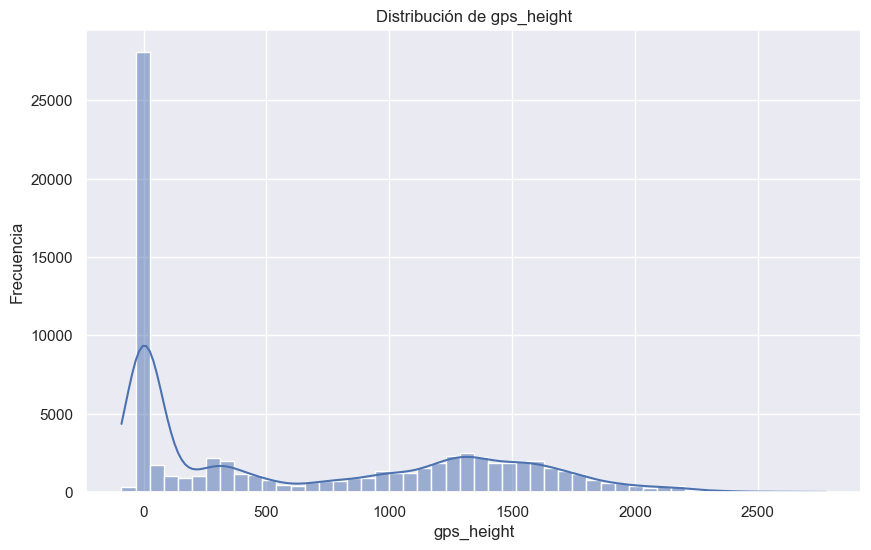

Número de registros con gps_height negativo: 1881


In [39]:
#Creación de una gráfica para ver la distribución de gps_height
plt.figure(figsize=(10,6))
sns.histplot(df_concat['gps_height'], bins=50, kde=True)
plt.title('Distribución de gps_height')
plt.xlabel('gps_height')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

#Ver cuántos valores negativos hay
negativos = (df_concat['gps_height'] < 0).sum()
print(f"Número de registros con gps_height negativo: {negativos}")


**gps_height** es la variable que nos presenta la altura a la que está situada la bomba de agua. 

Hay muchos ceros que pueden deberse a que muchas bombas estén a nivel del mar o a errores. También hay varios negativos, lo que indicaría que hay bombas por debajo del nivel del mar. 

Como es una variable con una distribución rara, he decidido realizar una **Transformación de Yeo-Johnson** para corregir la asimetría. 

In [40]:
from sklearn.preprocessing import PowerTransformer 

#Iniciar el transformador con Yeo-Johnson 
pt = PowerTransformer(method= 'yeo-johnson', standardize=False) 

#Transformar y crear una columna nueva 
df_concat['gps_height_yeo'] = pt.fit_transform(df_concat[['gps_height']])

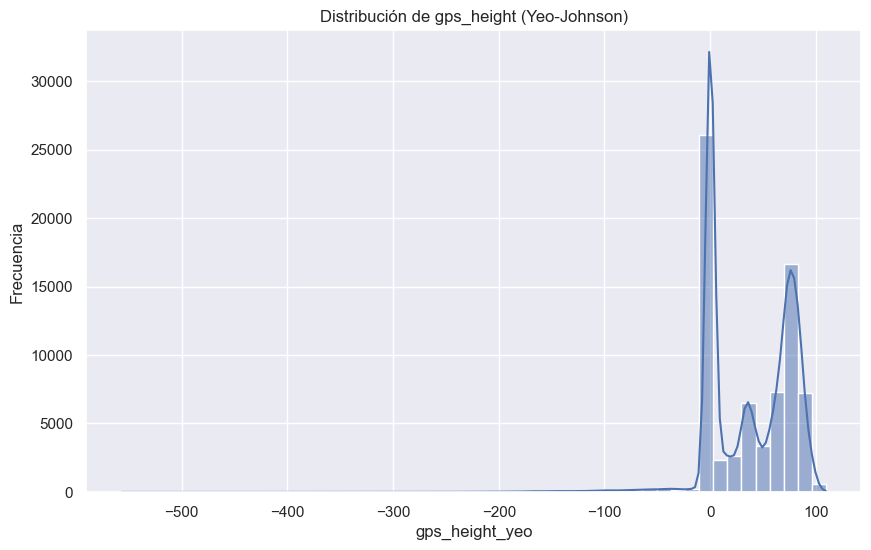

In [41]:
#Comprobar la nueva distribución 
plt.figure(figsize=(10, 6))
sns.histplot(df_concat['gps_height_yeo'], bins=50, kde=True)
plt.title('Distribución de gps_height (Yeo-Johnson)')
plt.xlabel('gps_height_yeo')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

Probé a estandarizar los valores pero me salía una distribución similar, así que decidí no incluirlo en el modelado. 

## 3.6. Gráficas para ver la distribución de las variables 

Voy a hacer gráficas de cada variable para ver un poco como se distribuyen para seguir trabajando con ellas, para su posterior transformación en numéricas. 

In [42]:
#Listas de cada tipo de variable (categóricas y numéricas) -> vuelvo a hacerlas porque he añadido nuevas 
categorical_cols_2= df_concat.select_dtypes(include=['object', 'category', 'bool']).columns
numeric_cols_2= df_concat.select_dtypes(exclude=['object', 'category', 'bool']).columns

In [43]:
#Función para hacer las gráficas de las variables numéricas 
def plot_numeric(df): 
    num_vars = df.select_dtypes(include=[np.number]).columns
    num_cols = 3
    num_rows = int(np.ceil(len(num_vars) / num_cols))

    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))
    axs = axs.flatten()

    for idx, col in enumerate(num_vars): 
        sns.histplot(df[col], bins=30, ax=axs[idx], kde=True)
        axs[idx].set_title(col) 

    for i in range(len(num_vars), len(axs)): 
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()

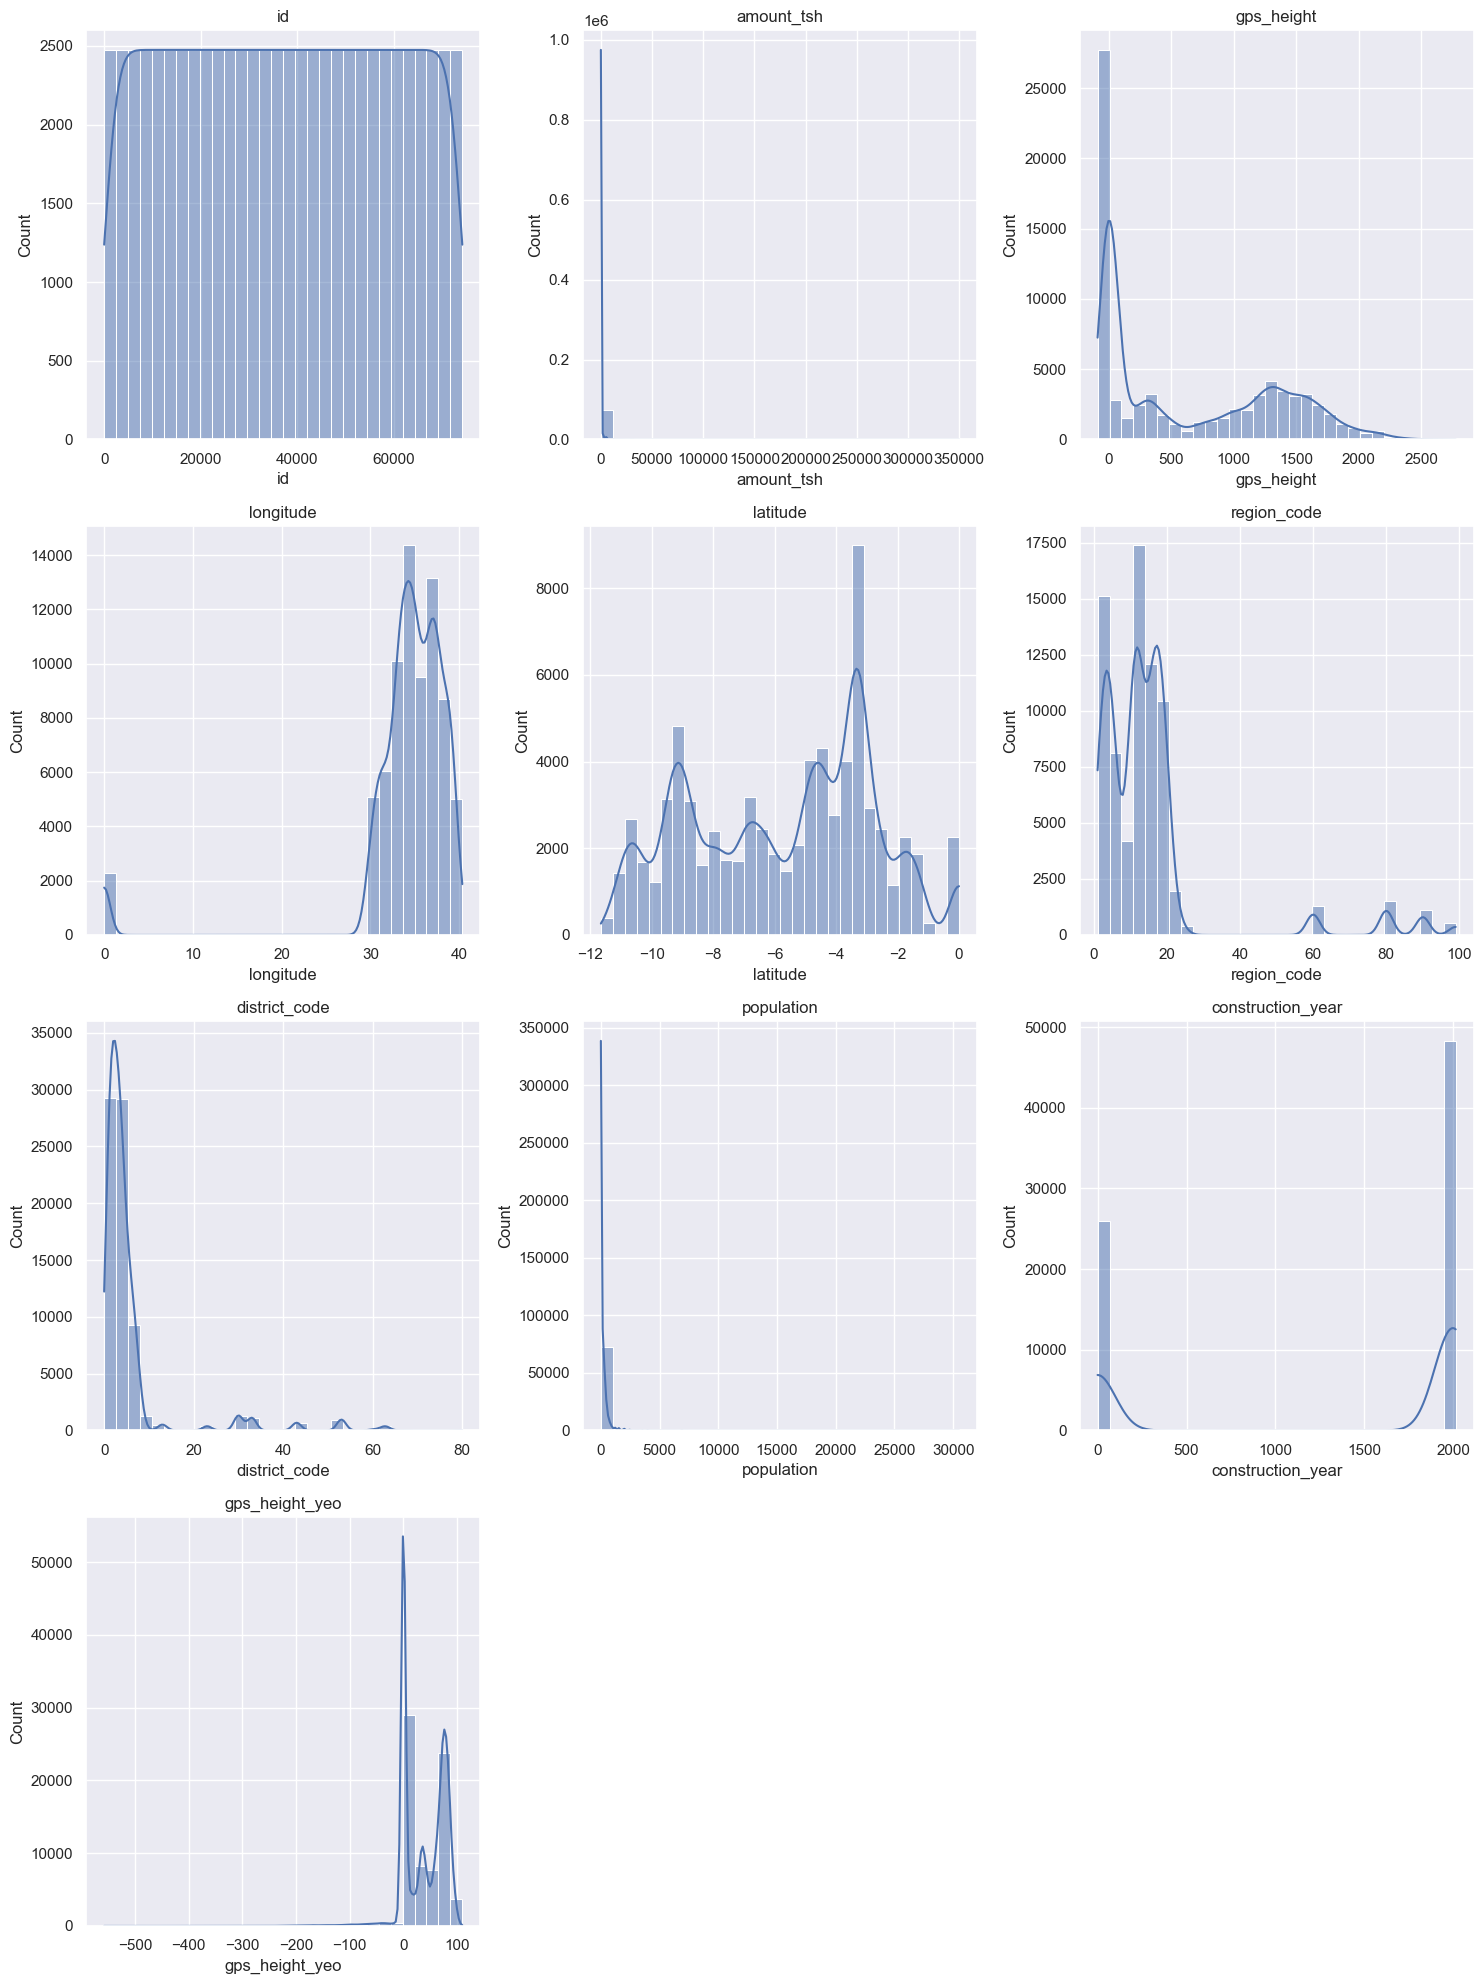

In [44]:
#Mostrar las gráficas
plot_numeric(df_concat)

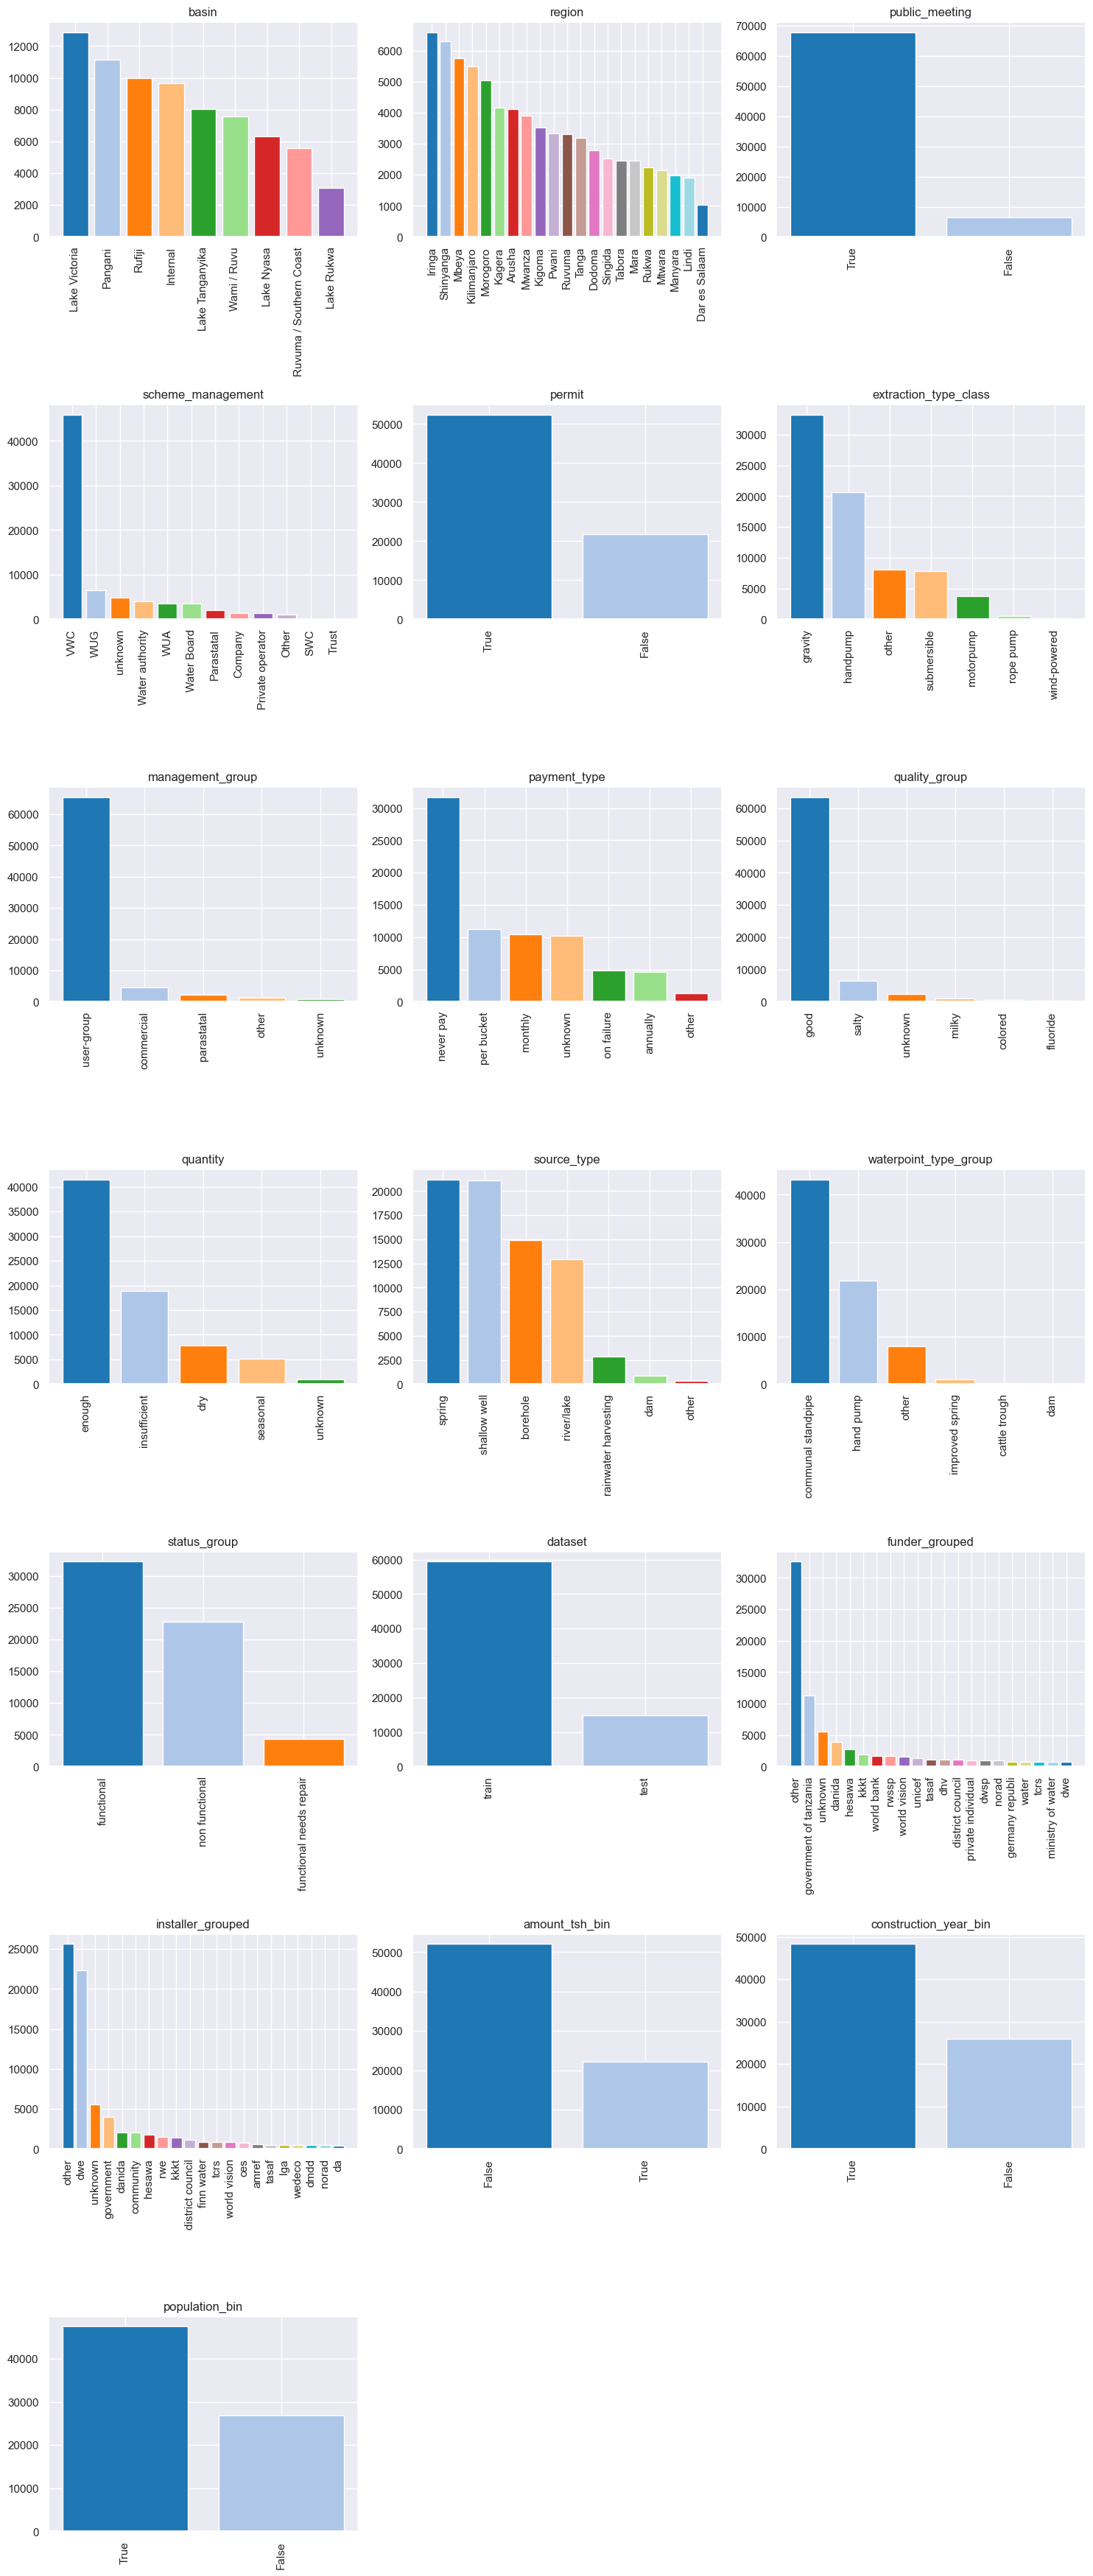

In [45]:
#Función para hacer las gráficas de las variables categóricas 
def plot_categorical(df, max_categories=30):
    cat_vars = df.select_dtypes(include=['object', 'category', 'bool']).columns
    num_cols = 3
    num_rows = int(np.ceil(len(cat_vars) / num_cols))

    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))
    axs = axs.flatten()

    idx = 0
    for col in cat_vars:
        if df[col].nunique() <= max_categories:
            counts = df[col].value_counts().head(30)
            colors = plt.cm.tab20.colors  # Paleta variada
            axs[idx].bar(counts.index.astype(str), counts.values, color=colors[:len(counts)])
            axs[idx].set_title(col)
            axs[idx].tick_params(axis='x', rotation=90)
            idx += 1

    for i in range(idx, len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()

#Mostrar las gráficas 
plot_categorical(df_concat)

## 3.7. Tratamiento de longitud y latitud


Las variables de **longitud** y **latitud** son variables que se entienden bien cuando se usan juntas. Por lo que una idea que se me ha ocurrido es hacer una transformación multiplicando ambas variables para obtener una variable nueva que **capture bien la ubicación combinada en el plano**.

In [46]:
#Creación de la nueva variable 
df_concat['lat_long']= df_concat['latitude'] * df_concat['longitude']

In [47]:
#Resumen para ver si existen outliers 
df_concat['lat_long'].describe()

count    74250.000000
mean      -202.541576
std        108.670550
min       -438.797610
25%       -297.625138
50%       -179.799076
75%       -120.109458
max         -0.000000
Name: lat_long, dtype: float64

Parece que no existen outliers.

Por otro lado, voy a crear también una nueva variable con ambas que sea la distancia de cada bomba al centro de Tanzania. Con ella voy a poder capturar la **posición relativa de cada bomba en el país con un solo número**. 

In [48]:
#Coordenadas aproximadas del centro de Tanzania
lat_c, long_c = -6.3690, 34.8888

#Calcular la distancia euclídea al centro 
df_concat['dist_to_center'] = np.sqrt((df_concat['latitude'] - lat_c) ** 2 + (df_concat['longitude'] - long_c) ** 2)

In [49]:
#Ver resumen estadístico de la nueva variable 
df_concat['dist_to_center'].describe()

count    74250.000000
mean         4.637731
std          5.609875
min          0.077192
25%          2.889477
50%          3.683164
75%          4.523564
max         35.465371
Name: dist_to_center, dtype: float64

# 4. TRANSFORMACIÓN A NUMÉRICAS 

En este apartado voy a transformar las variables categóricas a numéricas para poder seguir con el modelado.

In [50]:
#Ver el tipo de cada variable 
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     74250 non-null  int64  
 1   amount_tsh             74250 non-null  float64
 2   funder                 74250 non-null  object 
 3   gps_height             74250 non-null  int64  
 4   installer              74250 non-null  object 
 5   longitude              74250 non-null  float64
 6   latitude               74250 non-null  float64
 7   basin                  74250 non-null  object 
 8   region                 74250 non-null  object 
 9   region_code            74250 non-null  int64  
 10  district_code          74250 non-null  int64  
 11  lga                    74250 non-null  object 
 12  population             74250 non-null  int64  
 13  public_meeting         74250 non-null  bool   
 14  scheme_management      74250 non-null  object 
 15  pe

In [51]:
#En primer lugar, voy a eliminar las variables 'funder_clean' e 'installer_clean' porque eran intermediarias y no aportan mucha info
clean_drop= ['funder_clean', 'installer_clean']

#Eliminar las columnas que he descartado 
df_concat.drop(columns=clean_drop, inplace=True, errors='ignore')

## 4.1. Cambiar las booleanas a numéricas

Las variables booleanas están como True/False, por lo que voy a ponerlas como 1/0

In [52]:
#Convertir a int
df_concat[['amount_tsh_bin', 'construction_year_bin', 'population_bin', 'public_meeting', 'permit']] = df_concat[['amount_tsh_bin', 'construction_year_bin', 'population_bin','public_meeting', 'permit']].astype(int)

#Verificar las primeras filas
df_concat[['amount_tsh_bin', 'construction_year_bin', 'population_bin','public_meeting', 'permit']].head()

,amount_tsh_bin,construction_year_bin,population_bin,public_meeting,permit
0,1,1,1,1,0
1,0,1,1,1,1
2,1,1,1,1,1
3,0,1,1,1,1
4,0,0,0,1,1


## 4.2. Tramificación de variables 

Creo que hay algunas variables que deberían ser tramificicadas para poder incorporarlas mejor en el modelo. 

1. En primer lugar, voy a empezar con la variable **population**. Para ello voy a hacer una tramificación por quantiles, dividiendo los datos en 5 partes iguales en cantidad de registros. 

In [53]:
#Hacer la división por grupos 
df_concat['population_tram'] = pd.qcut(df_concat['population'], q=5, labels=['Very Low', 'Low', 'Medium', 'High'], duplicates='drop')

#Diccionario para mapear etiquetas a números
population_map = {'Very Low': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4}

#Aplicar el mapeo a los datos
df_concat['population_tram'] = df_concat['population_tram'].map(population_map)

In [54]:
#Comprobación
df_concat['population_tram'].value_counts()

population_tram
0    35616
3    14840
2    14810
1     8984
Name: count, dtype: int64

2. Voy a seguir con la variable **construction_year**. Creo que lo conveniente es agruparla por décadas.

In [55]:
#Crear los bins (límites) y etiquetas para las décadas
bins_year = [0, 1970, 1980, 1990, 2000, 2010, df_concat['construction_year'].max()]
labels_year = ['Desconocido', '1970s', '1980s', '1990s', '2000s', '2010s']

# Aplicar pd.cut para tramificar
df_concat['construction_year_tram'] = pd.cut(df_concat['construction_year'], bins=bins_year, labels=labels_year, include_lowest=True)

# Verificar la distribución de los tramos
df_concat['construction_year_tram'].value_counts()

construction_year_tram
Desconocido    27121
2000s          19899
1990s          11013
1980s           7110
1970s           5960
2010s           3147
Name: count, dtype: int64

In [56]:
#Asegurar que es string 
df_concat['construction_year_tram'] = df_concat['construction_year_tram'].astype(str)

#Aplicar el mapeo
year_map = {
    'Desconocido': 0, 
    '1970s': 1, 
    '1980s': 2, 
    '1990s': 3, 
    '2000s': 4, 
    '2010s': 5
}
df_concat['construction_year_tram'] = df_concat['construction_year_tram'].map(year_map)


In [57]:
#Verificar la distribución de los tramos
df_concat['construction_year_tram'].value_counts()

construction_year_tram
0    27121
4    19899
3    11013
2     7110
1     5960
5     3147
Name: count, dtype: int64

## 4.3. Estudio de correlaciones entre variables

Voy a inspeccionar la correlación entre las variables numéricas para poder ver si existe redundancia.

Como todas las variables con fuerte correlación son variables creadas a partir de otras con sus respectivas anteriores, no voy a eliminar ninguna. 

Quiero probar a ver cuales de estas variables que dan la misma info son las que influyen más en el modelo.

## 4.4. Creación de dummies 

Vpy a convertir en dummies aquellas variables que tienen pocas categorías. Como son: **quality_group, quantity y waterpoint_type_goup**

In [58]:
#Lista de variables para dummies 
var_dummies= ["quality_group", "quantity", "waterpoint_type_group"]

for k in var_dummies:
    dummies = pd.get_dummies(df_concat[k],prefix=k)
    df_concat = pd.concat([df_concat, dummies], axis=1)
    df_concat.drop(k, axis=1, inplace=True)

Las nuevas variables creadas con dummies son de tipo booleano (True/False) por lo que voy a cambiarlas a 1/0.

In [59]:
#Lista de variables que son booleanas
bool_vars= df_concat.select_dtypes(include=["bool"]).columns.tolist()
print(f"Variables dummies en el dataset: {bool_vars}")

Variables dummies en el dataset: ['quality_group_colored', 'quality_group_fluoride', 'quality_group_good', 'quality_group_milky', 'quality_group_salty', 'quality_group_unknown', 'quantity_dry', 'quantity_enough', 'quantity_insufficient', 'quantity_seasonal', 'quantity_unknown', 'waterpoint_type_group_cattle trough', 'waterpoint_type_group_communal standpipe', 'waterpoint_type_group_dam', 'waterpoint_type_group_hand pump', 'waterpoint_type_group_improved spring', 'waterpoint_type_group_other']


In [60]:
#Transformación a numéricas de las mismas 
for j in bool_vars:
    df_concat[j]= df_concat[j].apply(lambda x: 1 if x is True else 0)

In [61]:
#Comprobación de que se ha hecho bien con un ejemplo 
df_concat.quality_group_colored.value_counts()

quality_group_colored
0    73627
1      623
Name: count, dtype: int64

## 4.5. Label Encoder con variables categóricas (7 a 20 categorías)

Para las variables categóricas de 7 a 21 categorías voy a utilizar Label Encoder.

In [62]:
#Lista de variables 
vars_encod= ["basin", "region", "scheme_management", "extraction_type_class","payment_type", "source_type"]

le= LabelEncoder()

for k in vars_encod: 
    df_concat[k]= le.fit_transform(df_concat[k])

## 4.6. Variables que me faltaban 

Haciendo el primer modelo más abajo me he dado cuenta de que me faltaban algunas variables por transformar a numéricas, así que voy a hacerlo ahora.

Las variables **funder**, **installer** y **lga** originales voy a eliminarlas ya que tengo su versión agrupada. 

In [63]:
df_concat.drop(columns=['funder', 'installer', 'lga'], inplace=True, errors='ignore')

Para la variable **management_group** he decidido hacer dummies porque tiene pocas categorías.

In [64]:
df_concat = pd.get_dummies(df_concat, columns=['management_group'])

Por último, para las variables **funder_grouped, installer_grouped, lga_grouped y population_tram** he decidido hacer Label Encoder.

In [65]:
le = LabelEncoder()
for col in ['funder_grouped', 'installer_grouped', 'lga_grouped', 'population_tram']: 
    df_concat[col]= le.fit_transform(df_concat[col])

# 5. CREACIÓN DE DATASETS TRAIN Y TEST

## 5.1. Separar Train y Test

Voy a volver a separar el dataset a partir de la columna que cree al principio llamada 'dataset'. 

In [221]:
#Separar train y test
df_train = df_concat[df_concat['dataset'] == 'train'].copy()
df_test = df_concat[df_concat['dataset'] == 'test'].copy()

In [222]:
#Eliminar la columna 'dataset' porque ya no la necesito 
df_train.drop(columns=['dataset'], inplace=True)
df_test.drop(columns=['dataset', 'status_group'], inplace=True) #También elimino la target porque no hay para test

In [223]:
#Comprobar que los datasets creados están bien 
print(df_train.shape)
print(df_test.shape)

(59400, 51)
(14850, 50)


## 5.2. Transformar a numérica la variable target

In [224]:
#También voy a aplicar Label Encoding a la target, ya que tiene 3 categorías 
print(df_train.status_group.unique())

['functional' 'non functional' 'functional needs repair']


In [225]:
df_train["status_group"]= le.fit_transform(df_train["status_group"])

In [226]:
df_train.status_group.value_counts()

status_group
0    32259
2    22824
1     4317
Name: count, dtype: int64

--------------------------------------------------------------------------------------------------
Valores de la variable target (**status_group**)
- 0 = functional
- 1 = functional needs repair
- 2 = non functional


# 6. MODELADO 

## 6.1. Separar x_train e y_train

In [227]:
#En primer lugar voy a poner el 'id' como índice 
df_train.set_index('id', inplace=True)

In [228]:
#Definir las variables independientes (x) y la target (y) 
x_train= df_train.drop('status_group', axis=1)
y_train= df_train["status_group"]

#Para test eliminar el id 
x_test= df_test.drop(columns=['id'], errors= 'ignore')

## 6.2. Primer Modelo: RandomForest

In [229]:
#Dividir en entrenamiento y validación (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    x_train,
    y_train,
    test_size=0.2,
    random_state=0,
    stratify=y_train
)

In [75]:
from sklearn.ensemble import RandomForestClassifier

# Modelo base
model1 = RandomForestClassifier(random_state=0)
model1.fit(X_train, y_train)

# Predicción
y_pred = model1.predict(X_test)

In [77]:
#Función para mostrar métricas
def saca_metricas(y1, y2):
    print('Matriz de Confusión')
    print(confusion_matrix(y1, y2))
    
    print('\nAccuracy:', accuracy_score(y1, y2))

    print('\nPrecision (macro):', precision_score(y1, y2, average='macro'))
    print('Recall (macro):', recall_score(y1, y2, average='macro'))
    print('F1 Score (macro):', f1_score(y1, y2, average='macro'))

    print('\nPrecision (weighted):', precision_score(y1, y2, average='weighted'))
    print('Recall (weighted):', recall_score(y1, y2, average='weighted'))
    print('F1 Score (weighted):', f1_score(y1, y2, average='weighted'))


In [78]:
saca_metricas(y_test, y_pred)

Matriz de Confusión
[[5663  203  586]
 [ 426  302  135]
 [ 892   92 3581]]

Accuracy: 0.8035353535353535

Precision (macro): 0.7164893377849065
Recall (macro): 0.6707004260849895
F1 Score (macro): 0.6881866994978113

Precision (weighted): 0.7971679985927453
Recall (weighted): 0.8035353535353535
F1 Score (weighted): 0.7983353368460319


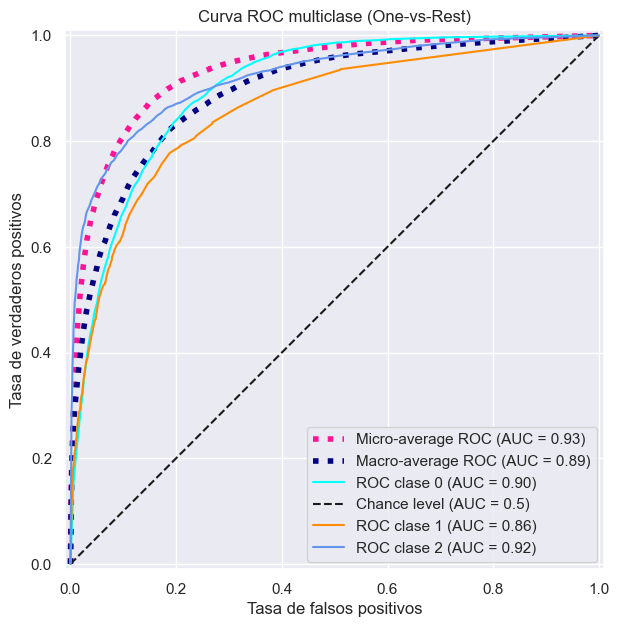

In [87]:
#Curva ROC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Paso 1: predecir probabilidades sobre el conjunto de validación
y_score = model1.predict_proba(X_test)

# Paso 2: binarizar y_test para multiclase
classes = model1.classes_  # ['functional', 'functional needs repair', 'non functional']
n_classes = len(classes)
y_onehot_test = label_binarize(y_test, classes=classes)

# Paso 3: calcular fpr, tpr y auc por clase
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Paso 4: calcular promedio macro y micro
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Paso 5: graficar curvas
fig, ax = plt.subplots(figsize=(7, 7))

plt.plot(
    fpr["micro"], tpr["micro"],
    label=f"Micro-average ROC (AUC = {roc_auc['micro']:.2f})",
    color="deeppink", linestyle=":", linewidth=4
)

plt.plot(
    fpr["macro"], tpr["macro"],
    label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})",
    color="navy", linestyle=":", linewidth=4
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, i], y_score[:, i],
        name=f"ROC clase {classes[i]}",
        color=color,
        ax=ax,
        plot_chance_level=(i == 0),  # dibuja línea base solo una vez
    )

ax.set(
    xlabel="Tasa de falsos positivos",
    ylabel="Tasa de verdaderos positivos",
    title="Curva ROC multiclase (One-vs-Rest)"
)
ax.legend(loc="lower right")
plt.grid(True)
plt.show()



### 6.2.1. Sacar predicciones 

In [ ]:
#Generar predicciones sobre x_test
predictions = model1.predict(x_test)

In [ ]:
predicciones1 = pd.DataFrame({'id': df_test['id'], 'status_group': predictions})
print(predicciones1.shape)  #Debería ser (14850, 2)

In [ ]:
#Mapeo de números a las categorías de DrivenData (Estaban en numéricas y no me dejaba subir el csv a DrivenData)
label_mapping = {
    0: 'functional',
    1: 'functional needs repair',
    2: 'non functional'
}

#Convertir las predicciones numéricas a sus nombres de clase
predicciones1['status_group'] = predicciones1['status_group'].map(label_mapping)

#Verificar los tipos de datos
print(predicciones1.dtypes)  #Ahora 'status_group' debe ser de tipo 'object' 

#Guardar el archivo corregido
predicciones1.to_csv('predicciones1.csv', index=False, encoding='utf-8')

**He añadido estas nuevas predicciones a DrivenData y he obtenido un score de 0.8063.**

Voy a probar con tuning de hiperparámetros a ver si sube o baja el score. 

## 6.3. Segundo Modelo: tuning de hiperparámetros de RandomForest

In [89]:
#Definir las variables independientes (x) y la target (y) 
x_train= df_train.drop('status_group', axis=1)
y_train= df_train["status_group"]

#Para test eliminar el id 
x_test= df_test.drop(columns=['id'], errors= 'ignore')

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#Definir la rejilla de hiperparámetros
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

#Inicializar el modelo base
rf = RandomForestClassifier(random_state=0)

#GridSearch con validación cruzada
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

#Ajustar sobre todo el conjunto de entrenamiento
grid.fit(x_train, y_train)

#Mostrar los mejores parámetros y score
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor score de validación:", grid.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Mejores hiperparámetros: {'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 300}
Mejor score de validación: 0.8090067340067341


In [92]:
#Extraer el mejor modelo del GridSearch
model2 = grid.best_estimator_

In [93]:
#Entrenar sobre todos los datos
model2.fit(x_train, y_train)

RandomForestClassifier(max_depth=20, max_features='log2', min_samples_split=5,
                       n_estimators=300, random_state=0)

In [97]:
#Usar el split interno original (con 20% para validación)
y_pred = model2.predict(X_test)
saca_metricas(y_test, y_pred)

Matriz de Confusión
[[6332   20  100]
 [ 320  471   72]
 [ 452   20 4093]]

Accuracy: 0.9171717171717172

Precision (macro): 0.9242408963692829
Recall (macro): 0.8079254279796307
F1 Score (macro): 0.8489517386809956

Precision (weighted): 0.9197980902011332
Recall (weighted): 0.9171717171717172
F1 Score (weighted): 0.9133985642798087


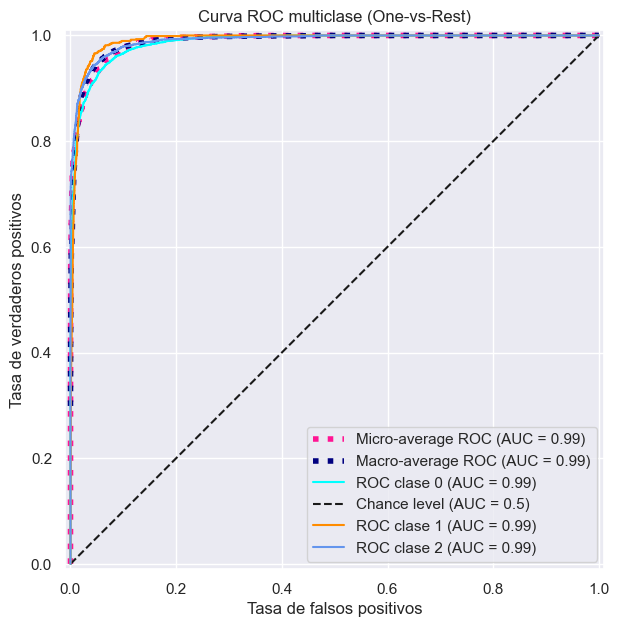

In [98]:
#Curva ROC
# Paso 1: predecir probabilidades sobre el conjunto de validación
y_score = model2.predict_proba(X_test)

# Paso 2: binarizar y_test para multiclase
classes = model2.classes_  # ['functional', 'functional needs repair', 'non functional']
n_classes = len(classes)
y_onehot_test = label_binarize(y_test, classes=classes)

# Paso 3: calcular fpr, tpr y auc por clase
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Paso 4: calcular promedio macro y micro
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Paso 5: graficar curvas
fig, ax = plt.subplots(figsize=(7, 7))

plt.plot(
    fpr["micro"], tpr["micro"],
    label=f"Micro-average ROC (AUC = {roc_auc['micro']:.2f})",
    color="deeppink", linestyle=":", linewidth=4
)

plt.plot(
    fpr["macro"], tpr["macro"],
    label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})",
    color="navy", linestyle=":", linewidth=4
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, i], y_score[:, i],
        name=f"ROC clase {classes[i]}",
        color=color,
        ax=ax,
        plot_chance_level=(i == 0),  # dibuja línea base solo una vez
    )

ax.set(
    xlabel="Tasa de falsos positivos",
    ylabel="Tasa de verdaderos positivos",
    title="Curva ROC multiclase (One-vs-Rest)"
)
ax.legend(loc="lower right")
plt.grid(True)
plt.show()


### 6.3.1. Sacar predicciones

In [100]:
y_pred_final = model2.predict(x_test)

In [102]:
predicciones2 = pd.DataFrame({'id': df_test['id'], 'status_group': y_pred_final})
print(predicciones2.shape)  #Debería ser (14850, 2)

(14850, 2)


In [103]:
#Mapeo de números a las categorías de DrivenData (Estaban en numéricas y no me dejaba subir el csv a DrivenData)
label_mapping = {
    0: 'functional',
    1: 'functional needs repair',
    2: 'non functional'
}
 
#Convertir las predicciones numéricas a sus nombres de clase
predicciones2['status_group'] = predicciones2['status_group'].map(label_mapping)

#Verificar los tipos de datos
print(predicciones2.dtypes)  #Ahora 'status_group' debe ser de tipo 'object' 

#Guardar el archivo corregido
predicciones2.to_csv('predicciones2.csv', index=False, encoding='utf-8')

id               int64
status_group    object
dtype: object


**Con el tuning de hiperparámetros he conseguido un score en DrivenData de 0.8176.**

Voy a seguir probando cosas a ver si puedo mejorar el modelo algo más. 

## 6.4. Tercer Modelo: Selección de variables (SelectKBest)

Como en el anterior notebook hice un modelado con la selección manual de las mejores variables, voy a probar ahora con SelectKBest.

### 6.4.1. Sacar predicciones

**Parece que esta prueba de modelado ha sido un poco peor que el segundo modelo, pero algo mejor que el primero. He obtenido un score de 0.8090.**

## 6.5. Cuarto Modelo: Selección de variables (Varianza)

Ahora voy a probar a hacer una selección de variables según su varianza con VarianceThreshold.

### 6.5.1. Sacar predicciones

**Este último modelo ha sido peor que los anteriores. He obtenido un score de 0.7801.**

## 6.6. Quinto Modelo: Balanceo de datos

Ahora voy a intentar hacer un balanceo de los datos ya que he visto en los primeros modelos que hay diferencias entre las categorías a predecir. La categoría de 'functional needs repair' parece que no se está prediciendo bien.

Voy a hacerlo con todas las variables porque parece que es lo que mejor está funcionando para el modelo. 

### 6.6.1. Sacar predicciones

**Este modelo ha mejorado un poco con respecto al enterior, pero no consigue superar al segundo modelo. He obtenido un score de 0.8034**

## 6.7. Sexto Modelo: Combinación Hiperparámetros + SMOTE 

Como he hecho el modelado anterior con el RandomForest sin ajustar los hiperparámetros, ahora voy a ajustarlos para ver si mejora más. 

### 6.7.1. Sacar predicciones

**Parece que, por ahora, el mejor modelo es con todas las variables, sin balanceo de datos y con los hiperparámetros ajustados. Con este último modelo he obtenido un score de 0.7949.**

## 6.8. Sexto Modelo: Uso de StandardScaler

Voy a normalizar los datos con StandardScaler para ver si con los datos escalados mejora el modelo en sí. 

### 6.8.1. Sacar predicciones

**Parece que ha mejorado un poco el modelo en comparación con los anteriores (menos el segundo modelo) ya que he obtenido un score en DriveData de 0.8114. Aún así, sigue sin ser el mejor modelo.**

## 6.9. Séptimo Modelo: XGBoost

Buscando información sobre como poder mejorar el modelo, he encontrado referencias a la librería XGBoost, por lo que voy a probar a ver si mejora o no el modelo. 

### 6.9.1. Sacar predicciones

**Este modelo, aunque parecía que podría ser mejor que RandomForest, me ha dado menor score en DrivenData (0.7830)**

## 6.10. Octavo Modelo: Corregir outliers y hacer RandomForest 

Me he dado cuenta que en el anterior notebook si que miré los outliers de algunas variables y los corregí, pero en este no lo he tenido en cuenta. Voy a volver a trabajar en el pre-procesado aquí y probar a volver a hacer el modelo con RandomForest con los hiperparámetros ajustados. 

### 6.10.1 Limpieza de outliers 

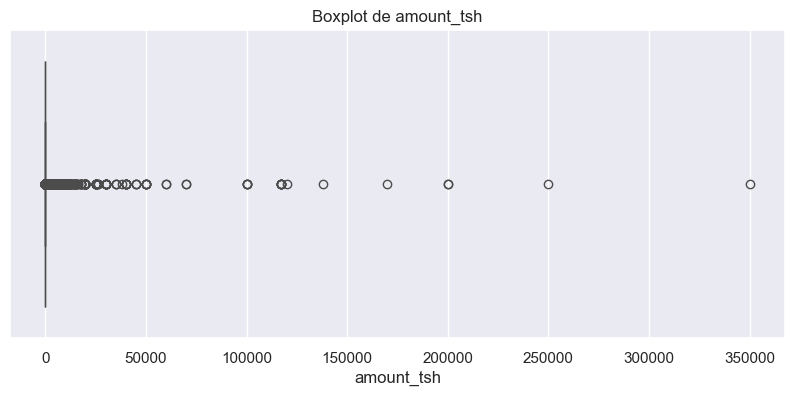

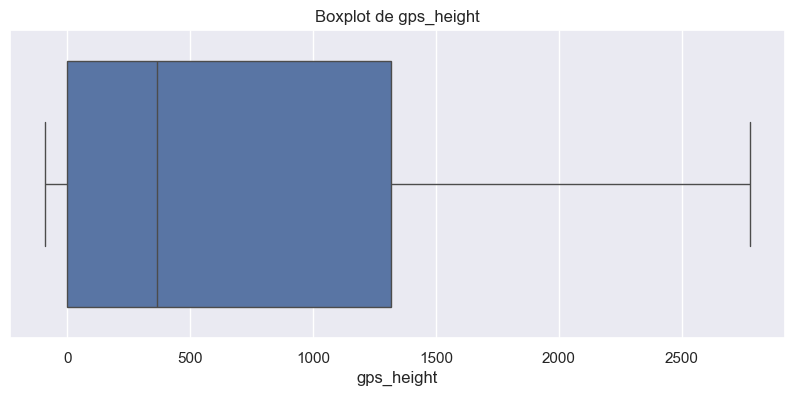

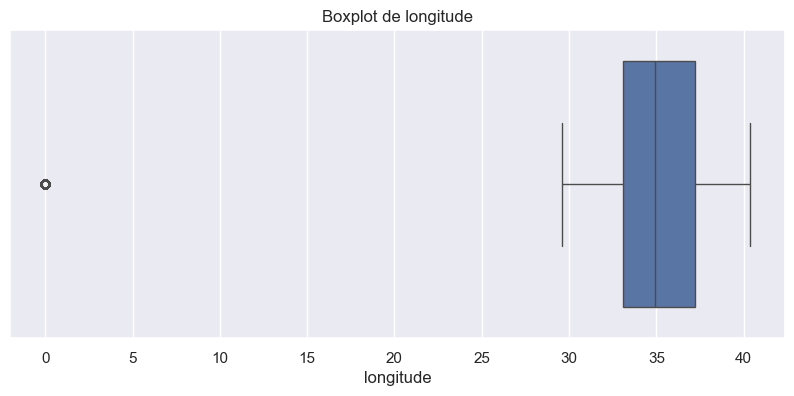

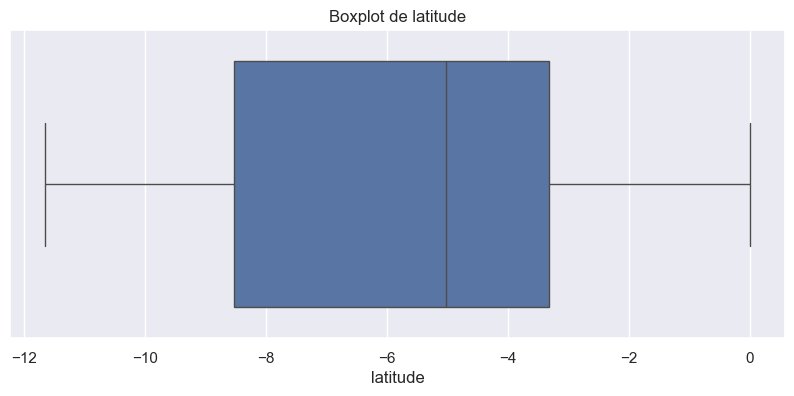

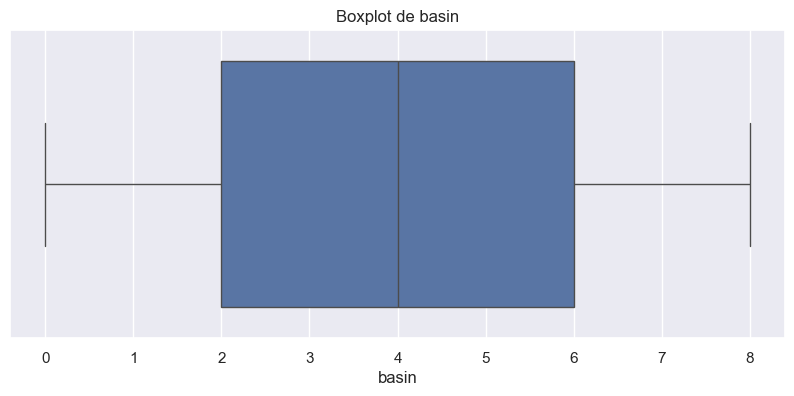

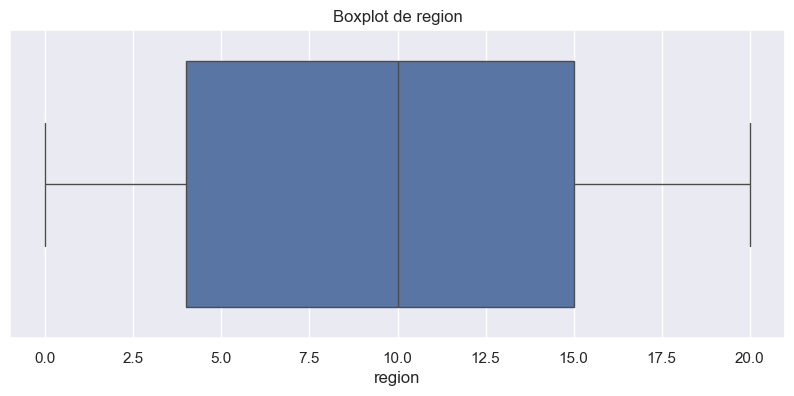

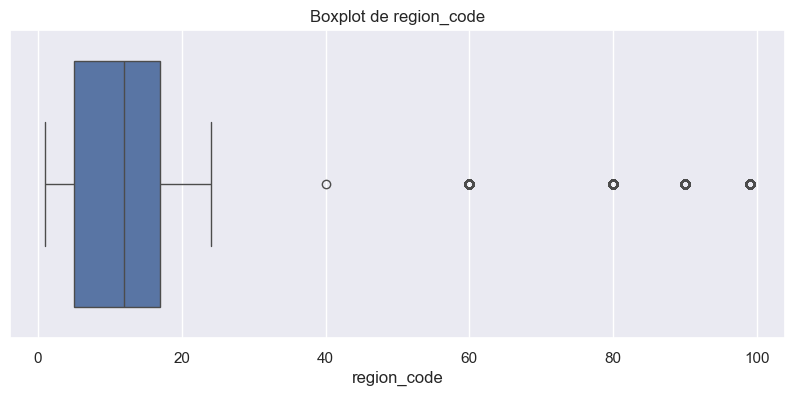

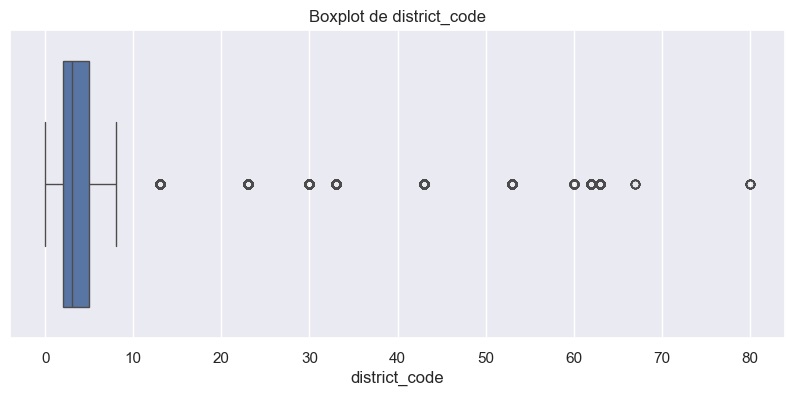

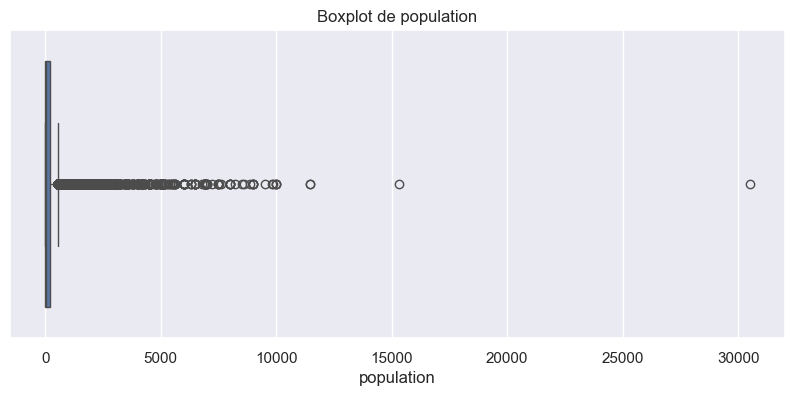

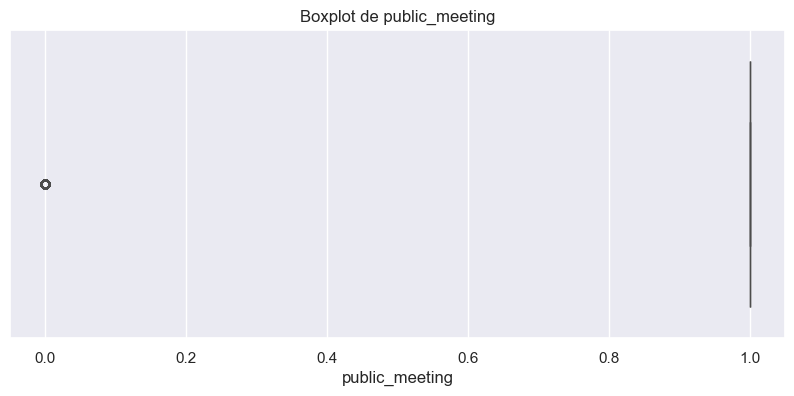

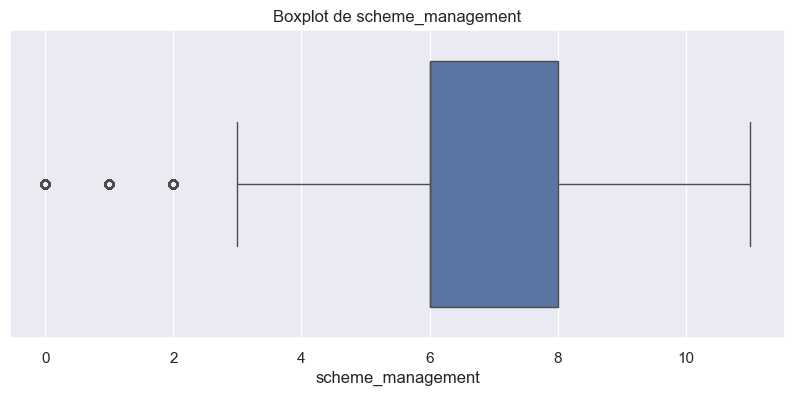

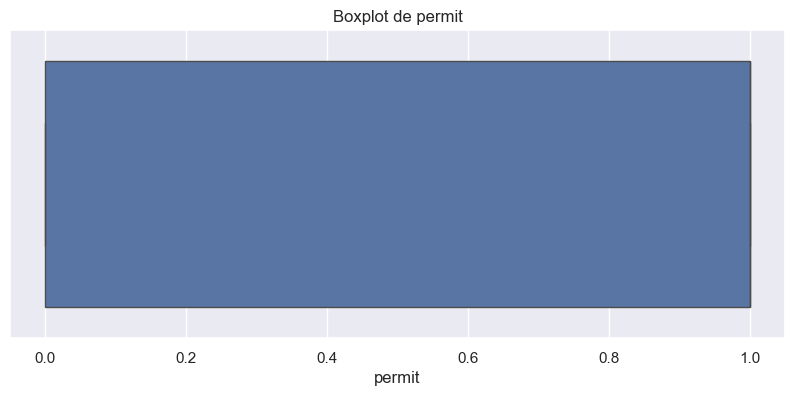

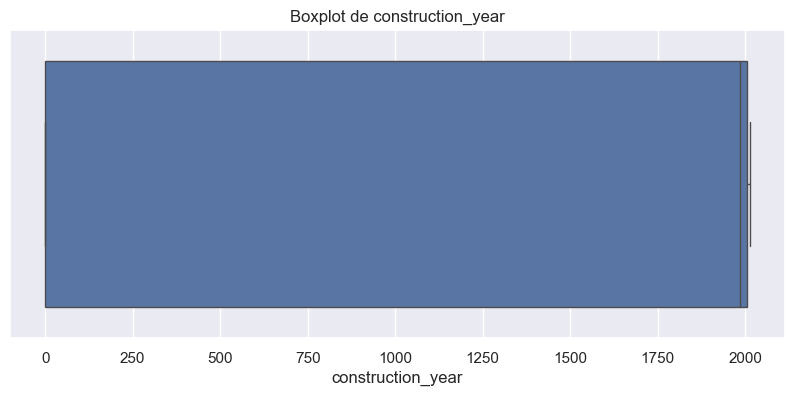

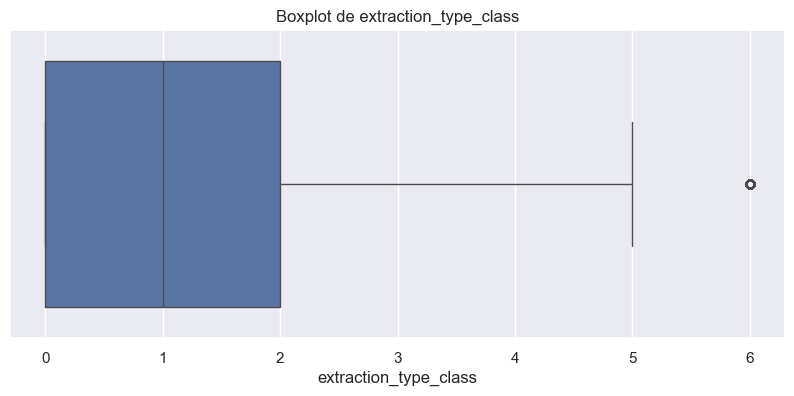

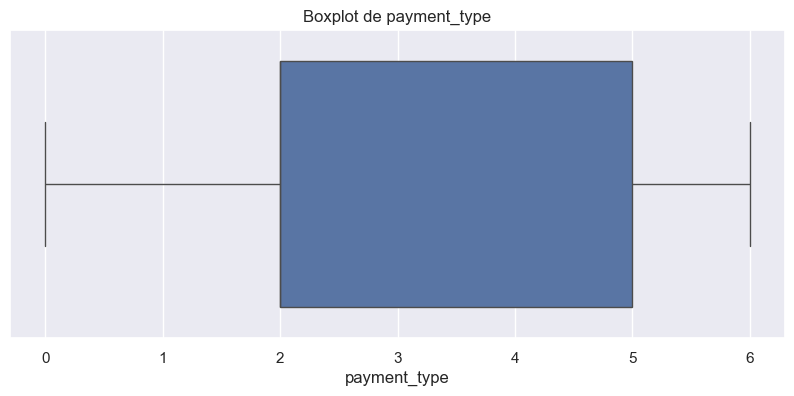

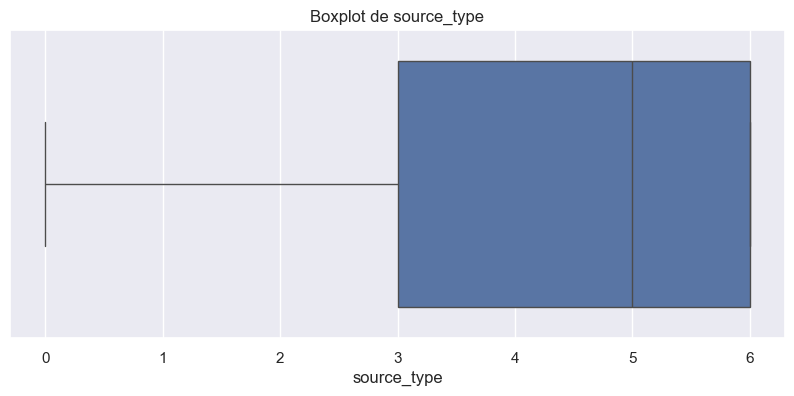

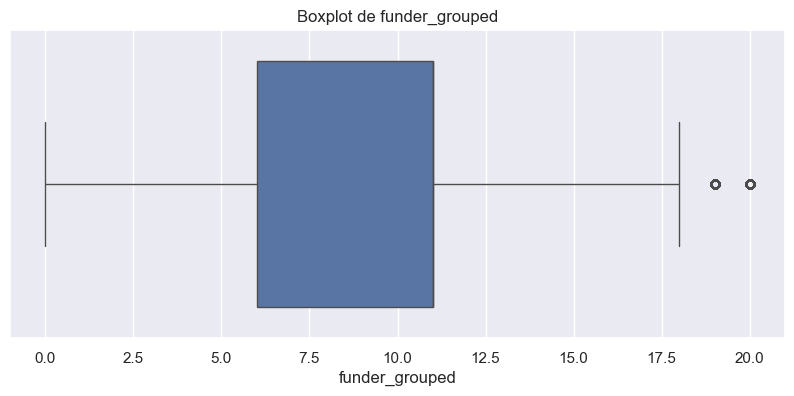

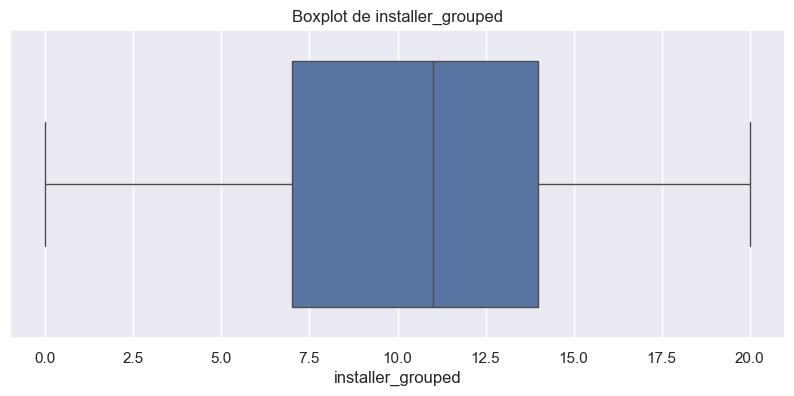

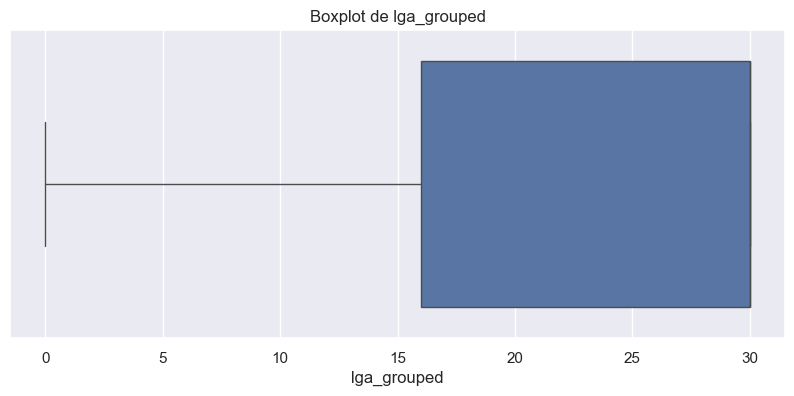

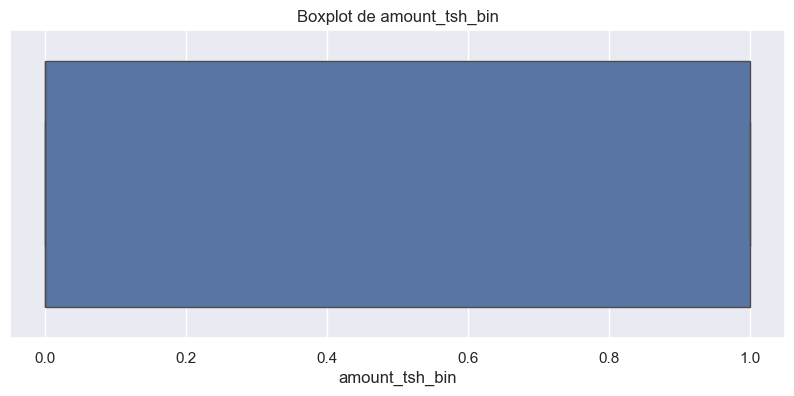

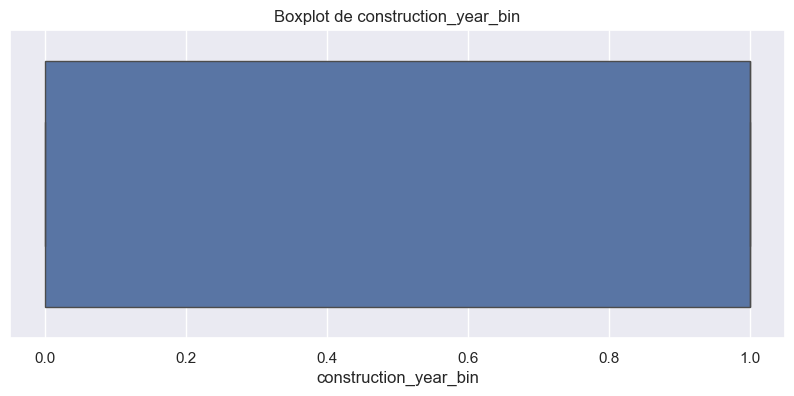

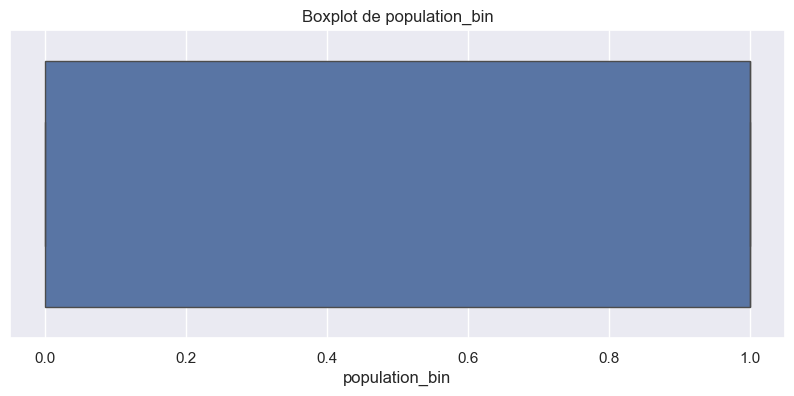

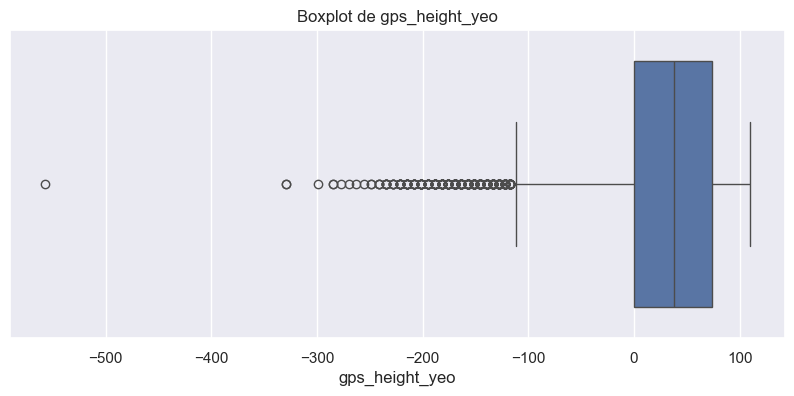

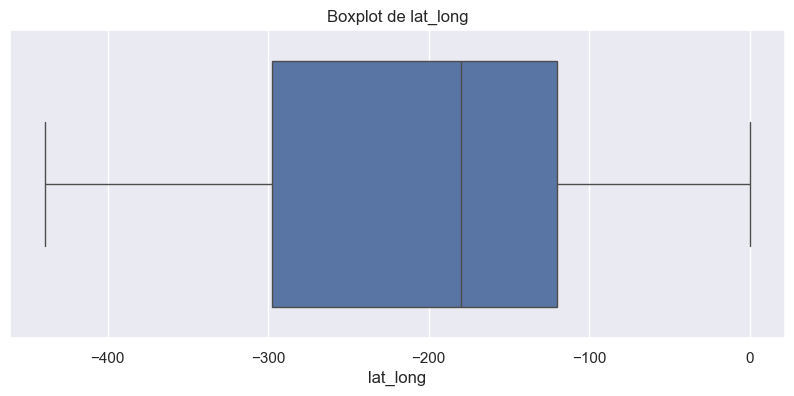

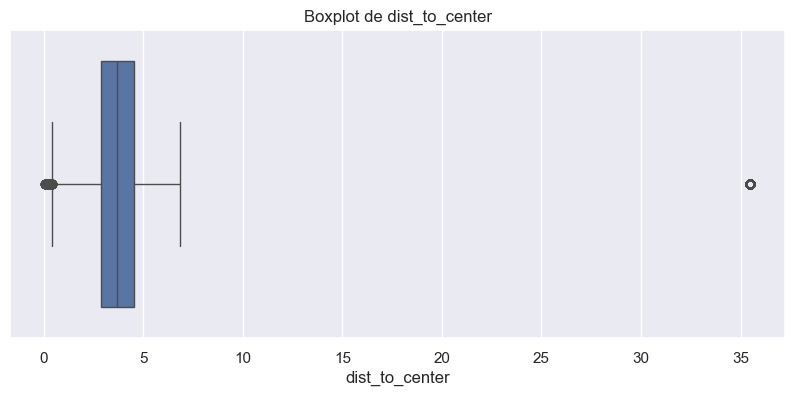

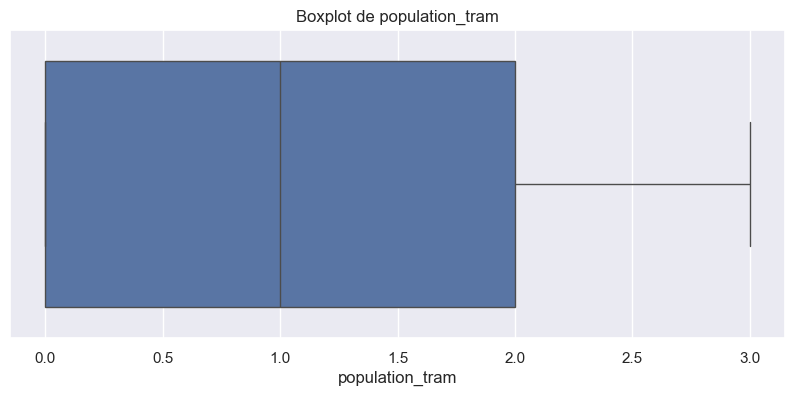

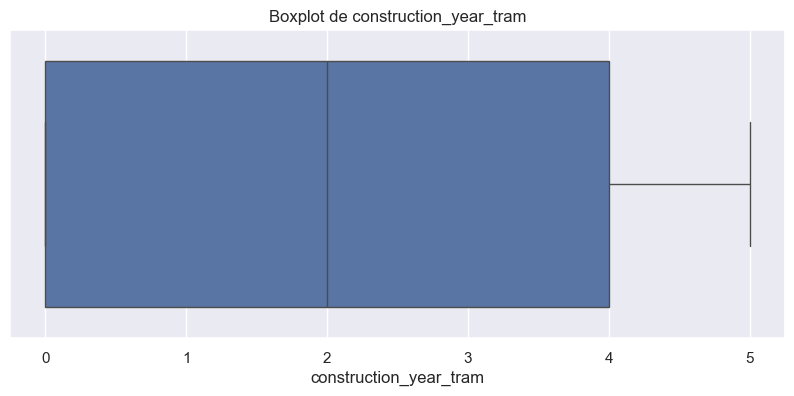

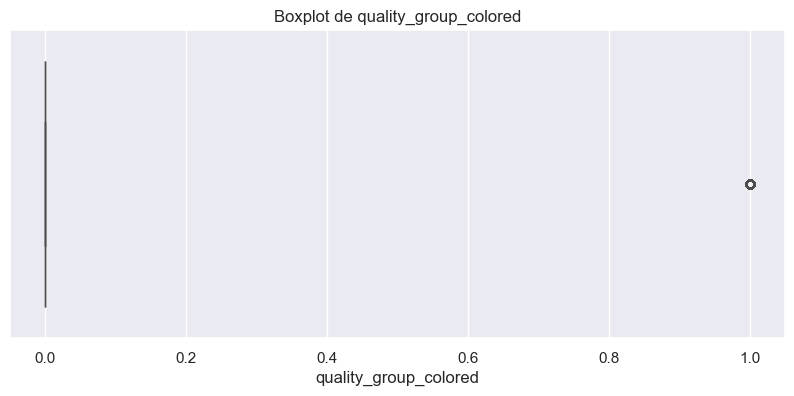

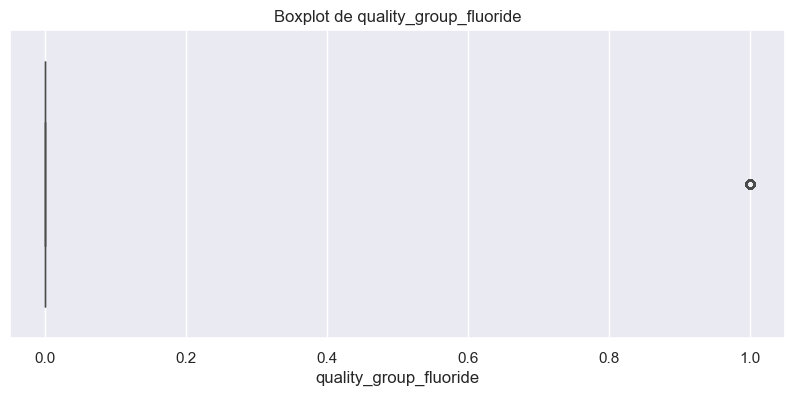

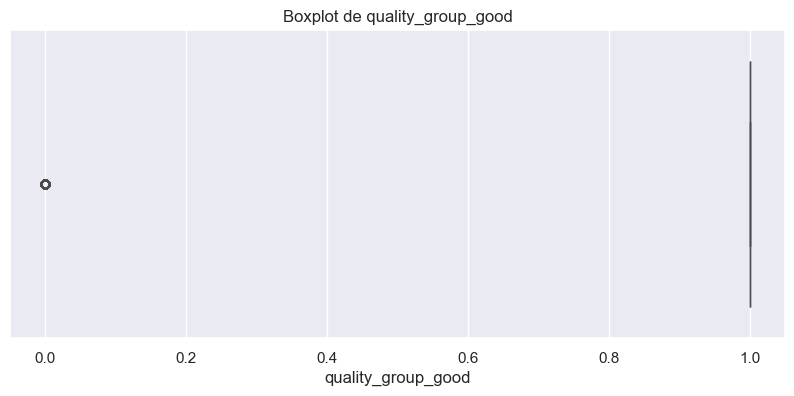

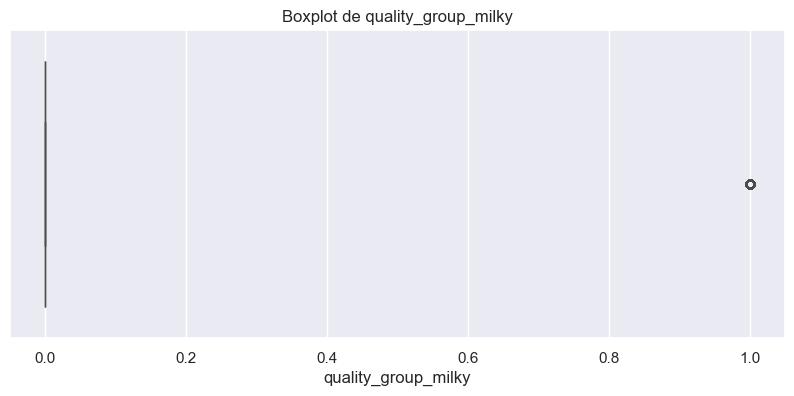

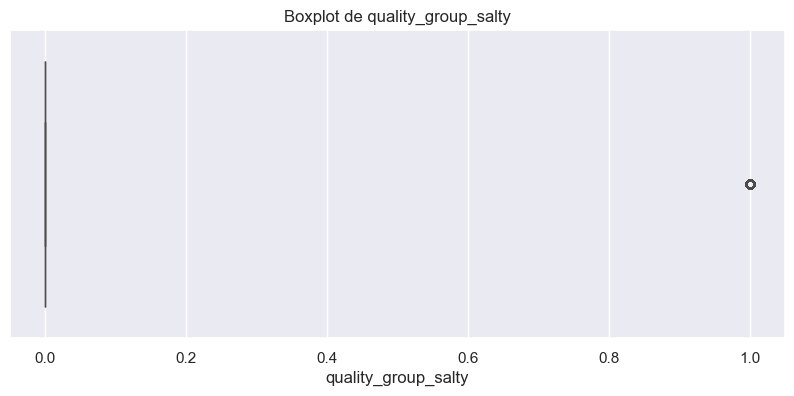

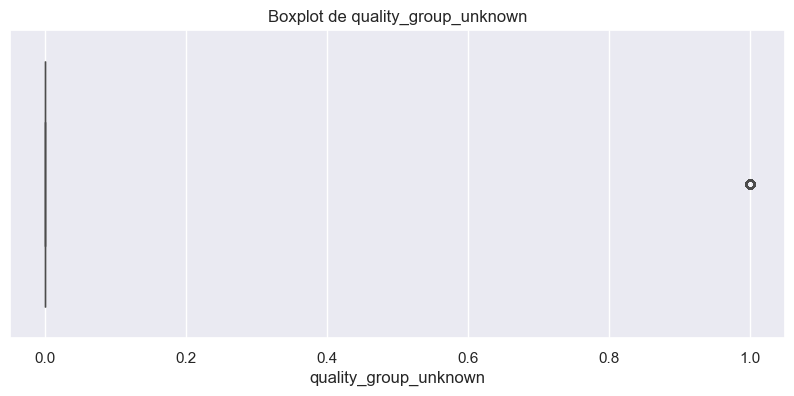

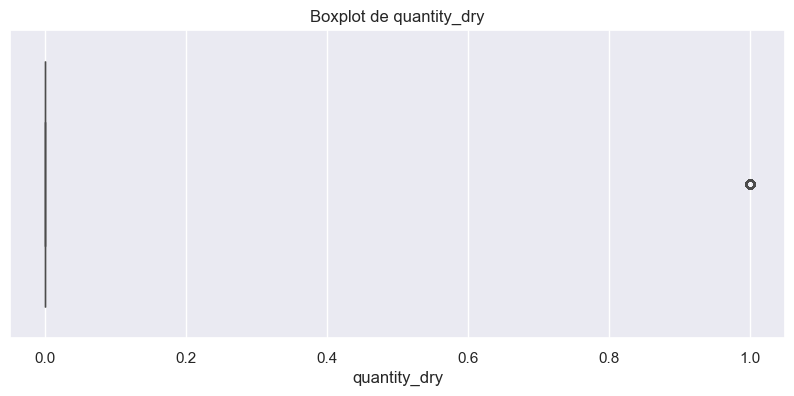

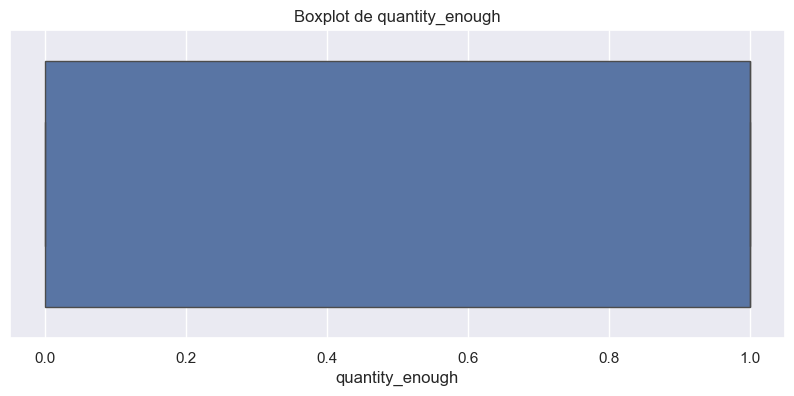

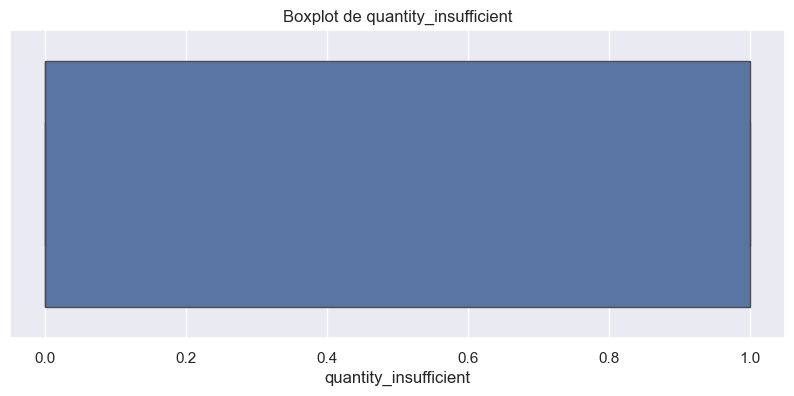

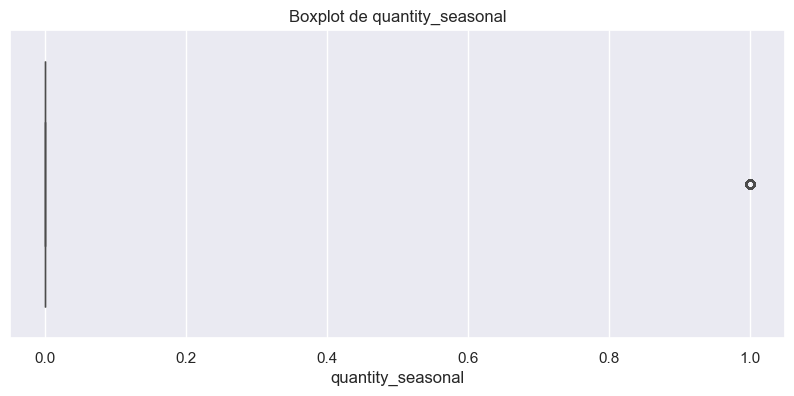

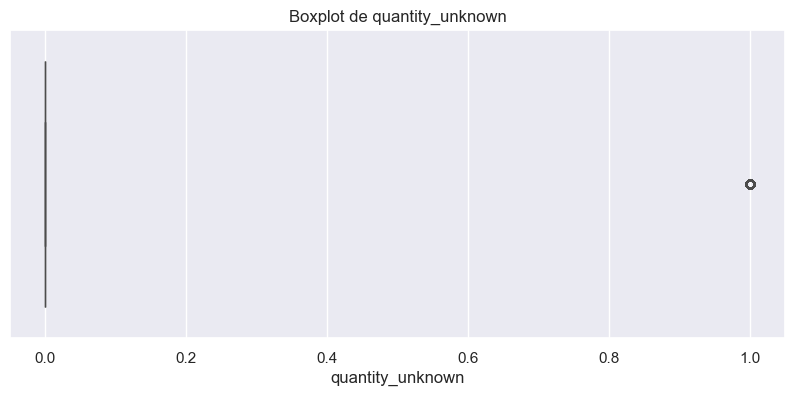

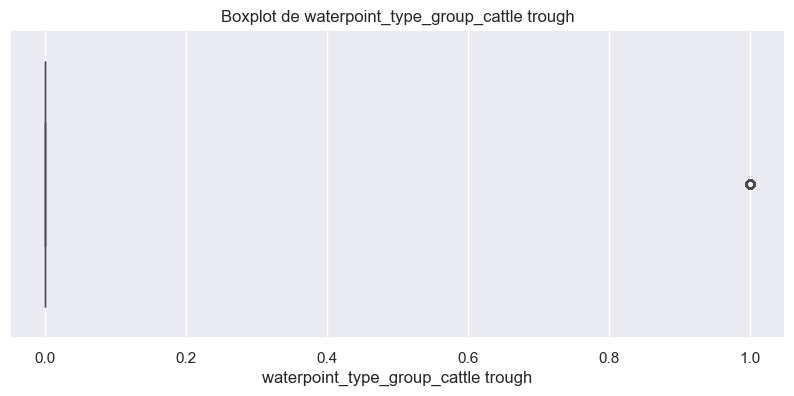

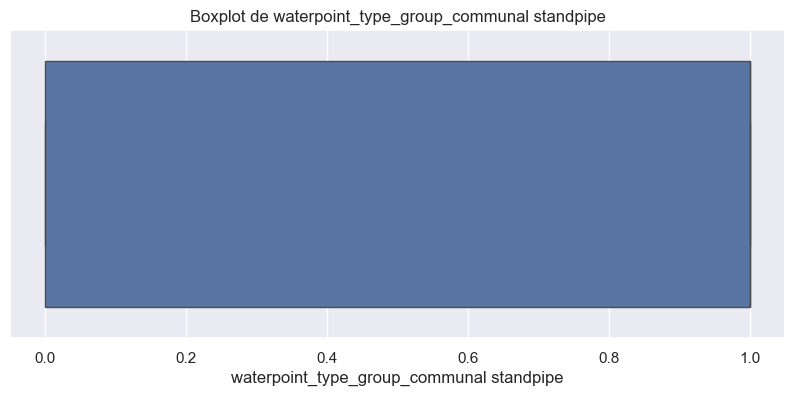

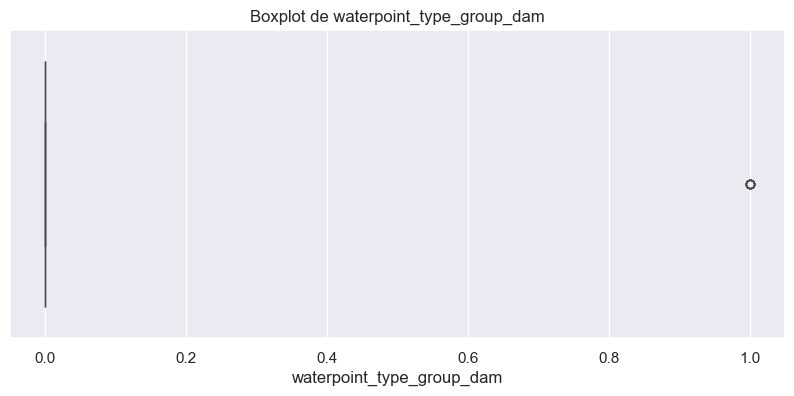

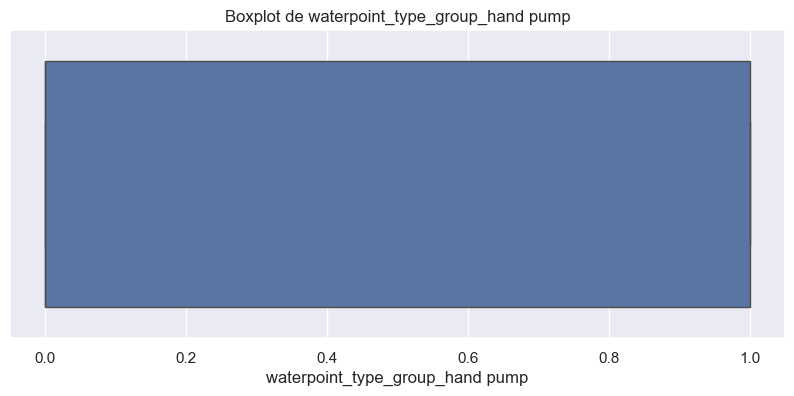

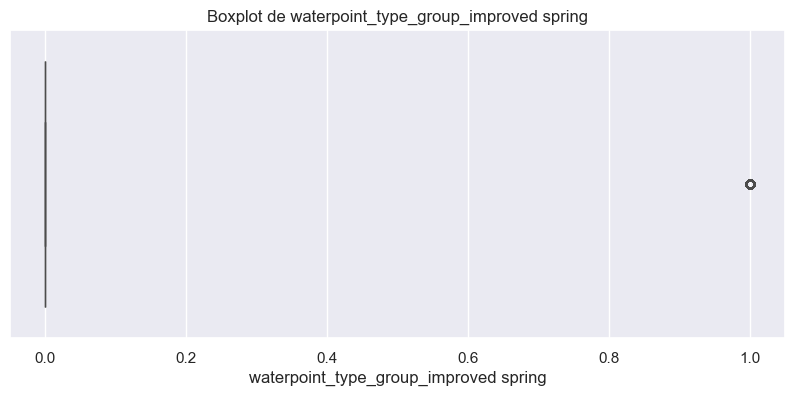

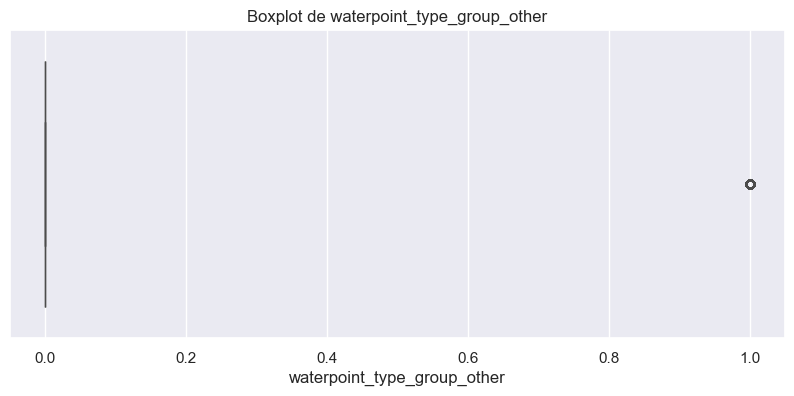

In [189]:
#Seleccionar las variables numéricas (sin incluir target ni id)
numeric_columns = df_concat.select_dtypes(include='number').columns.drop(['id'], errors='ignore')

#Crear boxplots para ver los outliers gráficamente 
for col in numeric_columns: 
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=df_concat, x=col)
    plt.title(f'Boxplot de {col}')
    plt.show()

Hay varias variables que tienen outliers pero la que más me preocupa en la variable **amount_tsh** ya que tienen muchos outliers por la derecha del boxplot. 

Por ello, voy a transformar a log esta variable y volver a hacer el modelo con este cambio. 

### 6.10.2. Separar Train y Test

### 6.10.3. Modelado 

### 6.10.4. Sacar predicciones 

**Este modelo ha mejorado con respecto a algunos anteriores y es, por ahora, el tercer mejor modelo que me ha puntuado DrivenData con un 0.8109**

## 6.11. Noveno Modelo: Uso de LightGBM

Buscando otras opciones de modelado que soporte multiclase, he encontrado la librería LightBGM que, según información que he encontrado, se suele usar en competiciones de datos y ML, por lo que voy a probar si mejora el modelo. 

### 6.11.1. Sacar predicciones

**Ya viendo el accuracy (0.7888888888888889) he pensado que no obtendría mejor score que los 3 mejores, pero igualmente he probado. Efectivamente, he obtenido peor score en DriveData (0.7881).**

# 7. CONCLUSIONES

Después de probar distintos pre-procesados y modelado de datos, no se me ocurre que más puedo hacer para mejorar el score. Sé que hay muchas más cosas por probar, pero por falta ya de tiempo y de ideas, he decidido dejarlo aquí. 

Finalmente, el modelo de **RandomForest con ajuste de hiperparámetros**, ha demostrado ser el más efectivo hasta el momento. Alcanzó un **score en DrivenData de 0.8176**, el más alto obtenido, lo cual indica una mejor capacidad de generalización respecto a otros enfoques probados. 

- He conseguido un **accuracy del 91,7%** y un **F1 macro de 0.849**, lo que refleja un rendimiento muy sólido.
- La curva ROC multiclase mostró un **AUC cercano a 0.99** para todas las clases, lo que evidencia una excelente capacidad discriminativa.
- A pesar de ello, se detecta cierta **dificultad del modelo para predecir correctamente la clase 'functional needs repair'**, lo cual es habitual debido al desbalance y ambigüedad de la categoría.

(Todas las métricas y curva ROC se pueden ver en el apartado referente al modelo). 


Inicialmente, el comportamiento tan positivo en la validación me hizo pensar en un **posible overfitting**. Sin embargo, el hecho de que el modelo haya obtenido un mejor rendimiento real en DrivenData me ha servido como validación externa, haciendo que confie en su capacidad de generalizar correctamente los datos. 

## 7.1. Gráfico de Importancias

In [244]:
def plot_feature_importance(model2, x_train):
    feat_importances = pd.DataFrame(model1.feature_importances_, index=X_train.columns, columns=["Importance"])
    feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
    
    fig = px.bar(feat_importances, x=feat_importances.index, y='Importance', title='Feature Importances', labels={'x': 'Features', 'Importance': 'Importance'}, template='plotly_white')
    fig.show()

    return feat_importances

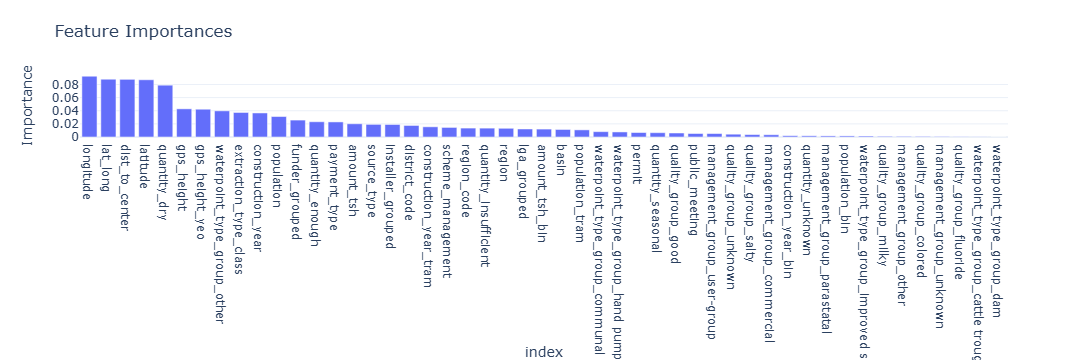

,Importance
longitude,0.092600
lat_long,0.088006
dist_to_center,0.087831
latitude,0.087161
quantity_dry,0.078930
gps_height,0.042885
gps_height_yeo,0.042315
waterpoint_type_group_other,0.039863
extraction_type_class,0.037353
construction_year,0.036642


In [245]:
plot_feature_importance(model2, x_train)

Según el gráfico de importancias de las variables, puedo considerar varios aspectos: 

1. Las variables referentes a la localización geográfica donde se encuentran las bombas de agua han sido las más influyentes en el modelo ('longitude', 'lat_long', 'dist_to_center' y 'latitude'). Esto sugiere que **la ubicación geográfica tiene una fuerte relación con el estado de funcionamiento de la bomba**. Problamente, haya algunas zonas donde las bombas fallen más que en otras.
2. Que la variable **'dist_to_center'**, que mide la distancias de las bombas al centro de Tanzania, sea tan importante puede estar indicándonos que **las bombas más alejadas de los núcleos urbanos o administrativos podrían tener más problemas**, pueden tener menor supervisión o acceso a reparaciones, lo que aumenta su probabilidad de fallo.
3. La variable **'quantity_dry'**, que indica bombas secas, está proporcionando mucha importancia al modelo. Esto es lógico, ya que **la falta de agua es un indicador claro de mal funcionamiento** o incluso abandono del punto de agua. 
4. Las dos variables referentes a la altitud de la bomba  ('gps_height' y 'gps_height_yeo') también nos proporcionan mucha importancia al modelo. Es posible que **la altitud esté relacionada con factores físicos como la presión del agua, o con el acceso a recursos y mantenimiento**, lo que afecta directamente a la operatividad de las bombas.

En conjunto, estas variables reflejan bien la lógica del problema: **la localización, la disponibilidad de agua y las condiciones del terreno** son factores clave que permiten al modelo identificar correctamente el estado funcional de las bombas. 

## 7.2. Captura de pantalla de DrivenData

Aquí voy a añadir las capturas de pantalla de la web con el score más alto y todas las subidas que he hecho.

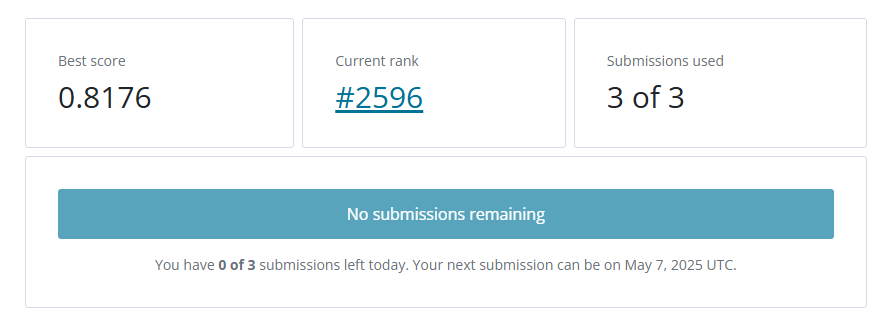

In [248]:
from IPython.display import Image
Image("score.png")

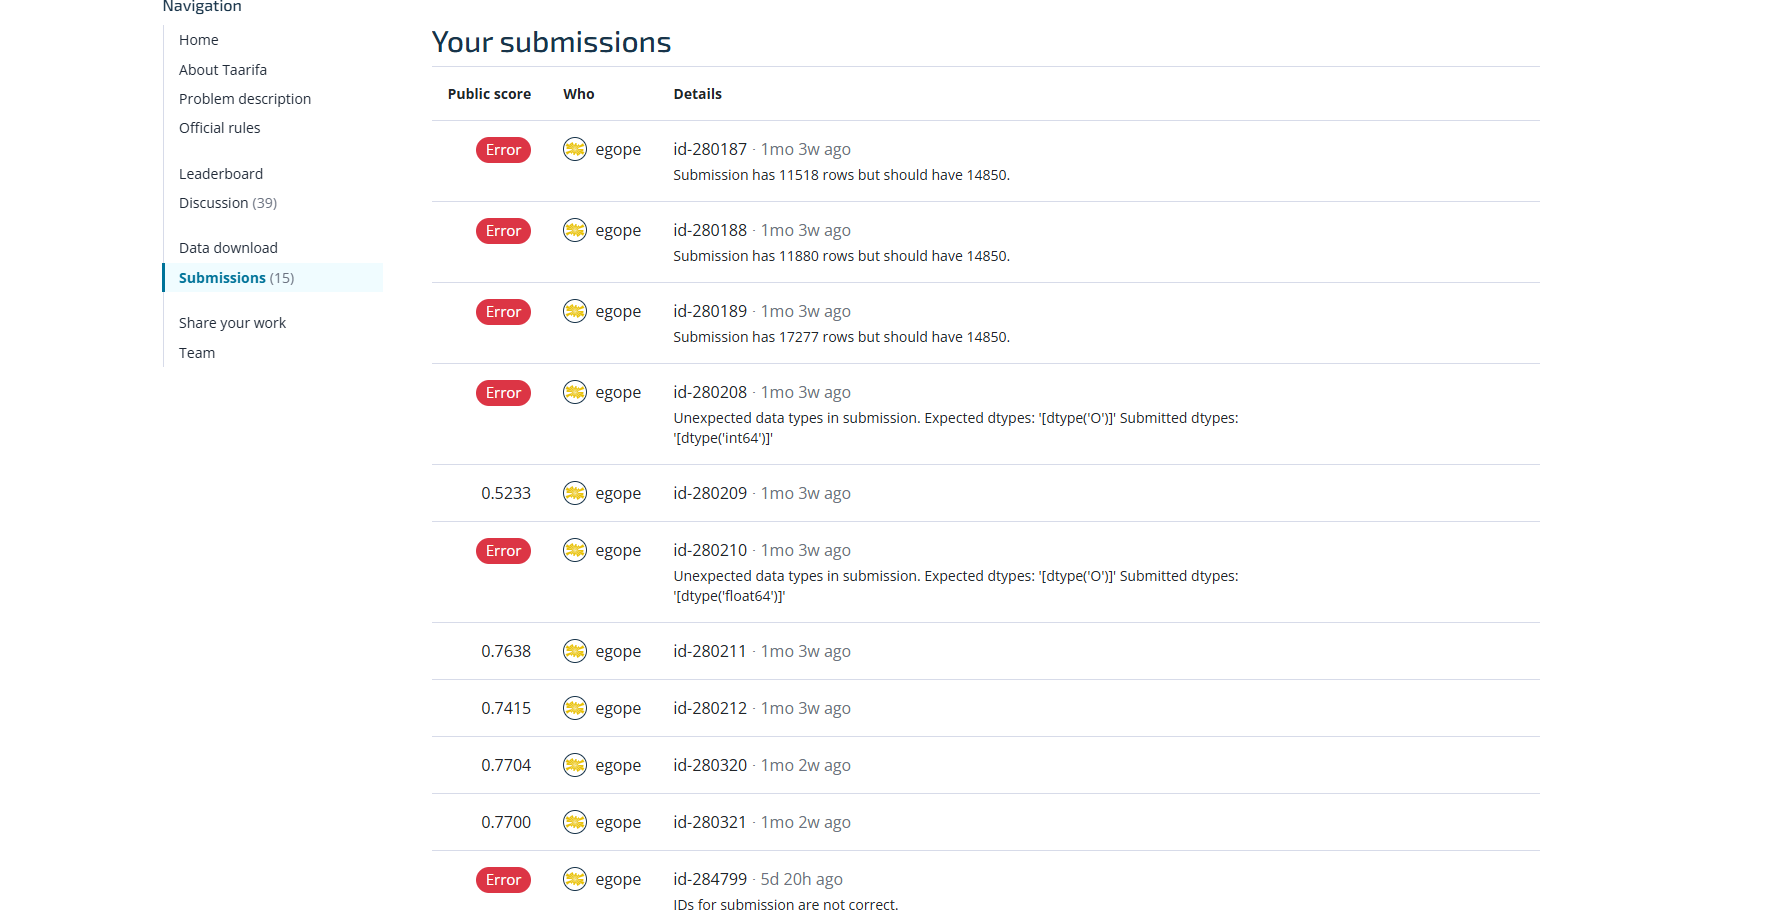

In [250]:
Image("subidas1.png")

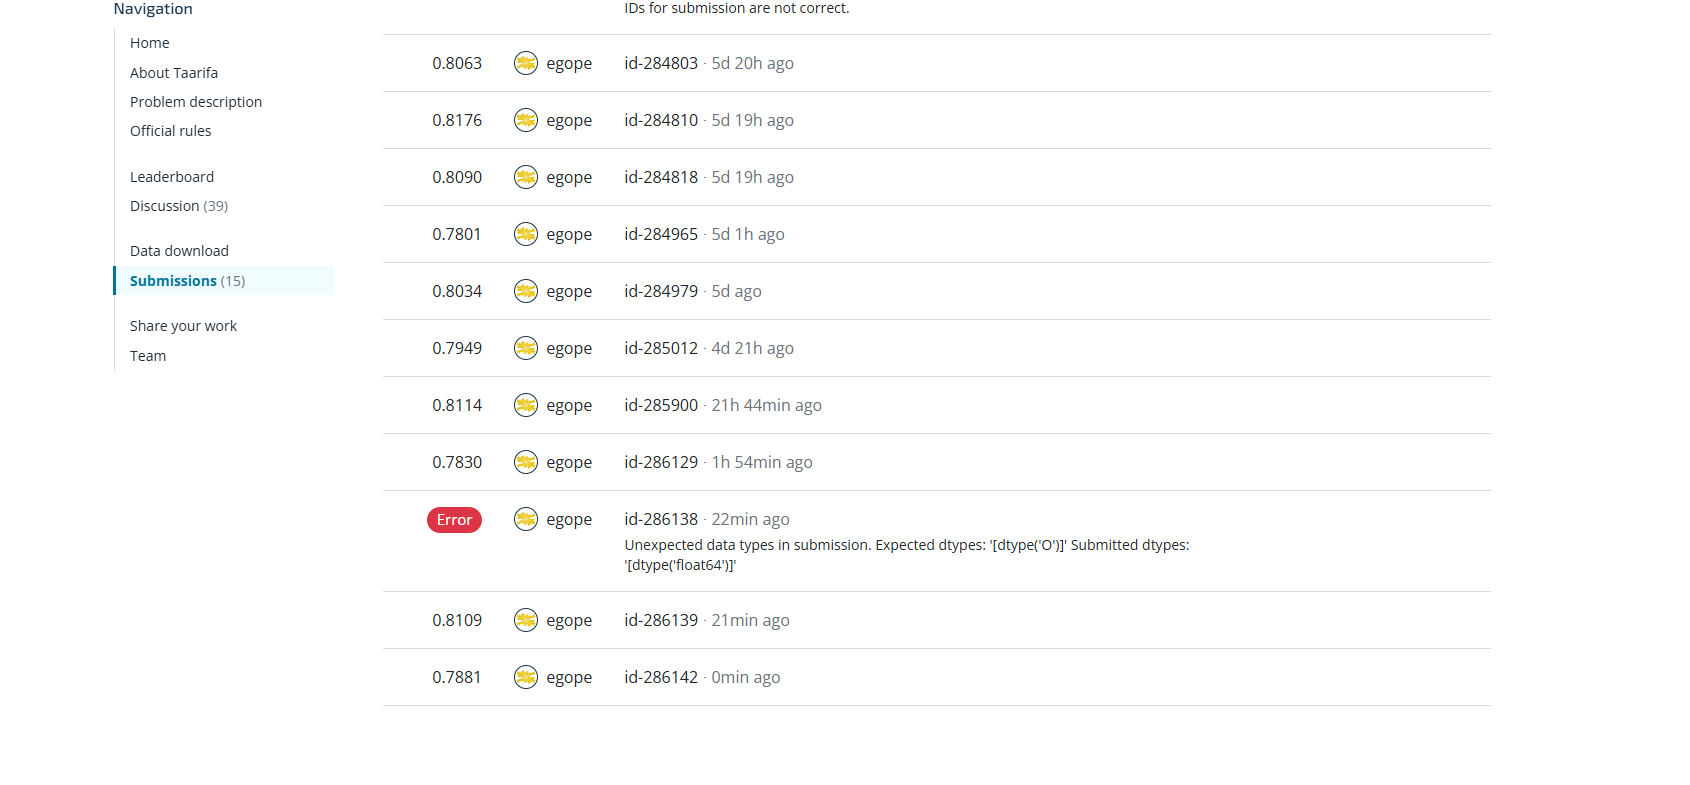

In [251]:
Image("subidas2.png")